# Analysis of Investigatory Stops by the Chicago Police Department

In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import time
import itertools
import prince as pn
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import umap
import warnings
warnings.filterwarnings("ignore")

C:\Users\nteut\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Dataset:
https://www.kaggle.com/milesius/cpd-investigatory-stop-reports

# Import and clean data

In [2]:
#Import data

df2016 = pd.read_csv('01-JAN-2016_28-FEB-2017.csv')
df2016.drop('RD_NO', axis=1, inplace=True)

df2017 = pd.read_csv('29-FEB-2017_16-JAN-2018.csv')

df = pd.concat([df2016, df2017])
df_clean = df.copy()

#Remove columns with 0 or 1 unique values
df_clean.drop(['JUVENILE_I', 'WARD', 'RES_WARD', 'BUS_WARD', 'TYPE_CD', 'COMPLETION_I', 'OTHER_CONTRABAND_I', 
               'OTHER_CONTRABAND_DESCR', 'SEARCH_OTHER_CONTRABAND_I', 'SEARCH_OTHER_CONTRABAND_DESCR', 
               'CITED_VIOLATIONS_CD'], axis=1, inplace=True)

#Remove columns that are not useful/too many unique string values
df_clean.drop(['CONTACT_CARD_ID', 'CARD_NO', 'SUBMITTING_BEAT_CD', 'CLOTHING_DESCR', 'HOTSPOT_NO', 'EVENT_NO', 'MISSION_NO', 
               'CPD_UNIT_NO', 'CREATED_BY', 'CREATED_DATE', 'MODIFIED_BY', 'MODIFIED_DATE', 'AGE_TO', 'STREET_NO', 
               'STREET_DIRECTION_CD', 'APT_NO', 'STREET_NME', 'CITY', 'STATE_CD', 'ZIP_CD', 'HALF_ADDRESS_I', 'DISTRICT', 
               'SECTOR', 'BEAT', 'RES_DISTRICT', 'RES_SECTOR', 'RES_BEAT', 'BUS_DISTRICT', 'BUS_SECTOR', 'BUS_BEAT', 
               'SUBMITTING_UNIT', 'CONTACT_TYPE_DESCR', 'MAKE_DESCR', 'STYLE_DESCR', 'MODEL_DESCR', 'V_YEAR', 'COLOR_BOTTOM', 
               'FO_EMPLOYEE_ID', 'SO_EMPLOYEE_ID', 'SUPV_EMPLOYEE_ID', 'GANG', 'KNOWN_HANGOUT', 'FACTION_NAME', 
               'CONTACT_CARD_STATUS_CD', 'LOCATION_CD', 'OTHER_WEAPON_DESCR', 'OTHER_CON_SUB', 'OTHER_CON_SUB_AMT', 
               'SEARCH_OTHER_WEAPON_DESCR', 'SEARCH_OTHER_CON_SUB_DESCR', 'SEARCH_OTHER_CON_SUB_AMT', 'FACIAL_HAIR_CD', 
               'ENFORCEMENT_ID_NO', 'CANNABIS_INVENTORY_NO', 'COCAINE_INVENTORY_NO', 'HEROIN_INVENTORY_NO', 
               'OTHER_CON_SUB_INVENTORY_NO', 'FIREARM_INVENTORY_NO', 'OTHER_WEAPON_INVENTORY_NO', 'ALCOHOL_INVENTORY_NO', 
               'PARA_INVENTORY_NO', 'STOLEN_PROPERTY_INVENTORY_NO', 'S_CANNABIS_INVENTORY_NO', 'S_COCAINE_INVENTORY_NO', 
               'S_HEROIN_INVENTORY_NO', 'S_OTHER_CON_SUB_INVENTORY_NO', 'S_FIREARM_INVENTORY_NO', 
               'S_OTHER_WEAPON_INVENTORY_NO', 'S_ALCOHOL_INVENTORY_NO', 'S_PARA_INVENTORY_NO', 
               'S_STOLEN_PROPERTY_INVENTORY_NO', 'GANG_OTHER', 'OTHER_DESCR', 'OTHER_INVENTORY_NO', 'S_OTHER_DESCR', 
               'S_OTHER_INVENTORY_NO', 'NAME', 'CONTACT_DATE'], axis=1, inplace=True)

#Remove redacted entries
for col in df_clean.columns:
    df_clean = df_clean[(df_clean[col] != 'REDACTED')]

In [3]:
#Binarize appropriate columns, replacing null values with 0

df_clean['NAME_VERIFIED_I'] = np.where(df_clean['NAME_VERIFIED_I'] == 'Y', 1, 0)
df_clean['HANDCUFFED_I'] = np.where(df_clean['HANDCUFFED_I'] == 'Y', 1, 0)
df_clean['VEHICLE_INVOLVED_I'] = np.where(df_clean['VEHICLE_INVOLVED_I'] == 'Y', 1, 0)
df_clean['GANG_LOOKOUT_I'] = np.where(df_clean['GANG_LOOKOUT_I'] == 'Y', 1, 0)
df_clean['GANG_SECURITY_I'] = np.where(df_clean['GANG_SECURITY_I'] == 'Y', 1, 0)
df_clean['INTIMIDATION_I'] = np.where(df_clean['INTIMIDATION_I'] == 'Y', 1, 0)
df_clean['SUSPECT_NARCOTIC_ACTIVITY_I'] = np.where(df_clean['SUSPECT_NARCOTIC_ACTIVITY_I'] == 'Y', 1, 0)
df_clean['ENFORCEMENT_ACTION_TAKEN_I'] = np.where(df_clean['ENFORCEMENT_ACTION_TAKEN_I'] == 'Y', 1, 0)
df_clean['INDICATIVE_DRUG_TRANSACTION_I'] = np.where(df_clean['INDICATIVE_DRUG_TRANSACTION_I'] == 'Y', 1, 0)
df_clean['INDICATIVE_CASING_I'] = np.where(df_clean['INDICATIVE_CASING_I'] == 'Y', 1, 0)
df_clean['FITS_DESCRIPTION_I'] = np.where(df_clean['FITS_DESCRIPTION_I'] == 'Y', 1, 0)
df_clean['PROXIMITY_TO_CRIME_I'] = np.where(df_clean['PROXIMITY_TO_CRIME_I'] == 'Y', 1, 0)
df_clean['FITS_DESCRIPTION_OFFENDER_I'] = np.where(df_clean['FITS_DESCRIPTION_OFFENDER_I'] == 'Y', 1, 0)
df_clean['GANG_NARCOTIC_RELATED_I'] = np.where(df_clean['GANG_NARCOTIC_RELATED_I'] == 'Y', 1, 0)
df_clean['OTHER_FACTOR_I'] = np.where(df_clean['OTHER_FACTOR_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_I'] = np.where(df_clean['PAT_DOWN_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_CONSENT_I'] = np.where(df_clean['PAT_DOWN_CONSENT_I'] == 'Y', 1, 0)
df_clean['PAT_DOWN_RECEIPT_GIVEN_I'] = np.where(df_clean['PAT_DOWN_RECEIPT_GIVEN_I'] == 'Y', 1, 0)
df_clean['VERBAL_THREATS_I'] = np.where(df_clean['VERBAL_THREATS_I'] == 'Y', 1, 0)
df_clean['KNOWLEDGE_OF_PRIOR_I'] = np.where(df_clean['KNOWLEDGE_OF_PRIOR_I'] == 'Y', 1, 0)
df_clean['ACTIONS_INDICATIVE_VIOLENCE_I'] = np.where(df_clean['ACTIONS_INDICATIVE_VIOLENCE_I'] == 'Y', 1, 0)
df_clean['VIOLENT_CRIME_I'] = np.where(df_clean['VIOLENT_CRIME_I'] == 'Y', 1, 0)
df_clean['SUSPICIOUS_OBJECT_I'] = np.where(df_clean['SUSPICIOUS_OBJECT_I'] == 'Y', 1, 0)
df_clean['OTHER_REASONABLE_SUSPICION_I'] = np.where(df_clean['OTHER_REASONABLE_SUSPICION_I'] == 'Y', 1, 0)
df_clean['WEAPON_OR_CONTRABAND_FOUND_I'] = np.where(df_clean['WEAPON_OR_CONTRABAND_FOUND_I'] == 'Y', 1, 0)
df_clean['FIREARM_I'] = np.where(df_clean['FIREARM_I'] == 'Y', 1, 0)
df_clean['COCAINE_I'] = np.where(df_clean['COCAINE_I'] == 'Y', 1, 0)
df_clean['HEROIN_I'] = np.where(df_clean['HEROIN_I'] == 'Y', 1, 0)
df_clean['OTHER_WEAPON_I'] = np.where(df_clean['OTHER_WEAPON_I'] == 'Y', 1, 0)
df_clean['CANNABIS_I'] = np.where(df_clean['CANNABIS_I'] == 'Y', 1, 0)
df_clean['OTHER_CON_SUB_I'] = np.where(df_clean['OTHER_CON_SUB_I'] == 'Y', 1, 0)
df_clean['SEARCH_I'] = np.where(df_clean['SEARCH_I'] == 'Y', 1, 0)
df_clean['SEARCH_CONSENT_I'] = np.where(df_clean['SEARCH_CONSENT_I'] == 'Y', 1, 0)
df_clean['SEARCH_CONTRABAND_FOUND_I'] = np.where(df_clean['SEARCH_CONTRABAND_FOUND_I'] == 'Y', 1, 0)
df_clean['SEARCH_FIREARM_I'] = np.where(df_clean['SEARCH_FIREARM_I'] == 'Y', 1, 0)
df_clean['SEARCH_COCAINE_I'] = np.where(df_clean['SEARCH_COCAINE_I'] == 'Y', 1, 0)
df_clean['SEARCH_HEROIN_I'] = np.where(df_clean['SEARCH_HEROIN_I'] == 'Y', 1, 0)
df_clean['SEARCH_OTHER_WEAPON_I'] = np.where(df_clean['SEARCH_OTHER_WEAPON_I'] == 'Y', 1, 0)
df_clean['SEARCH_CANNABIS_I'] = np.where(df_clean['SEARCH_CANNABIS_I'] == 'Y', 1, 0)
df_clean['SEARCH_OTHER_CON_SUB_I'] = np.where(df_clean['SEARCH_OTHER_CON_SUB_I'] == 'Y', 1, 0)
df_clean['BODY_CAMERA_I'] = np.where(df_clean['BODY_CAMERA_I'] == 'Y', 1, 0)
df_clean['CAR_CAMERA_I'] = np.where(df_clean['CAR_CAMERA_I'] == 'Y', 1, 0)
df_clean['VEHICLE_STOPPED_I'] = np.where(df_clean['VEHICLE_STOPPED_I'] == 'Y', 1, 0)
df_clean['INFORMATION_REFUSED_I'] = np.where(df_clean['INFORMATION_REFUSED_I'] == 'Y', 1, 0)
df_clean['GANG_OTHER_I'] = np.where(df_clean['GANG_OTHER_I'] == 'Y', 1, 0)
df_clean['ALCOHOL_I'] = np.where(df_clean['ALCOHOL_I'] == 'Y', 1, 0)
df_clean['PARA_I'] = np.where(df_clean['PARA_I'] == 'Y', 1, 0)
df_clean['STOLEN_PROPERTY_I'] = np.where(df_clean['STOLEN_PROPERTY_I'] == 'Y', 1, 0)
df_clean['SEARCH_PROPERTY_I'] = np.where(df_clean['SEARCH_PROPERTY_I'] == 'Y', 1, 0)
df_clean['S_ALCOHOL_I'] = np.where(df_clean['S_ALCOHOL_I'] == 'Y', 1, 0)
df_clean['S_PARA_I'] = np.where(df_clean['S_PARA_I'] == 'Y', 1, 0)
df_clean['S_STOLEN_PROPERTY_I'] = np.where(df_clean['S_STOLEN_PROPERTY_I'] == 'Y', 1, 0)
df_clean['S_OTHER_I'] = np.where(df_clean['S_OTHER_I'] == 'Y', 1, 0)

In [4]:
#Convert data types of numeric columns

df_clean['CONTACT_HOUR'] = pd.to_numeric(df_clean['CONTACT_HOUR'], errors='coerce')
df_clean['AGE'] = pd.to_numeric(df_clean['AGE'], errors='coerce')
df_clean['HEIGHT'] = pd.to_numeric(df_clean['HEIGHT'], errors='coerce')
df_clean['WEIGHT'] = pd.to_numeric(df_clean['WEIGHT'], errors='coerce')
df_clean['AREA'] = pd.to_numeric(df_clean['AREA'], errors='coerce')
df_clean['RES_AREA'] = pd.to_numeric(df_clean['RES_AREA'], errors='coerce')
df_clean['BUS_AREA'] = pd.to_numeric(df_clean['BUS_AREA'], errors='coerce')
df_clean['DISPERSAL_TIME'] = pd.to_numeric(df_clean['DISPERSAL_TIME'], errors='coerce')
df_clean['NUMBER_OF_PERSONS_DISPERSED'] = pd.to_numeric(df_clean['NUMBER_OF_PERSONS_DISPERSED'], errors='coerce')

In [5]:
#Fill null values with 0 when applicable

df_clean['DISPERSAL_TIME'].fillna(0, inplace=True)
df_clean['NUMBER_OF_PERSONS_DISPERSED'].fillna(0, inplace=True)

In [6]:
#Fill null values with unknown codes

df_clean['SEX_CODE_CD'].fillna('X', inplace=True)
df_clean['RACE_CODE_CD'].fillna('U', inplace=True)
df_clean['BUILD_CODE_CD'].fillna('XXX', inplace=True)
df_clean['EYE_COLOR_CODE_CD'].fillna('XXX', inplace=True)
df_clean['HAIR_COLOR_CODE_CD'].fillna('XXX', inplace=True)
df_clean['HAIR_STYLE_CODE_CD'].fillna('XXX', inplace=True)
df_clean['COMPLEXION_CODE_CD'].fillna('XXX', inplace=True)
df_clean['EVENT_ASSIGNEED_BY_CD'].fillna('OTH', inplace=True)
df_clean['ENFORCEMENT_TYPE_CD'].fillna('OTH', inplace=True)
df_clean['MAKE_CD'].fillna('XXX', inplace=True)
df_clean['STYLE_CD'].fillna('XX', inplace=True)
df_clean['COLOR_TOP'].fillna('XXX', inplace=True)

In [7]:
#Reformat mixed numeric-string object variables

df_clean['COCAINE_AMOUNT'] = df_clean['COCAINE_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['HEROIN_AMOUNT'] = df_clean['HEROIN_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['CANNABIS_AMOUNT'] = df_clean['CANNABIS_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_COCAINE_AMOUNT'] = df_clean['SEARCH_COCAINE_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_HEROIN_AMOUNT'] = df_clean['SEARCH_HEROIN_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')
df_clean['SEARCH_CANNABIS_AMOUNT'] = df_clean['SEARCH_CANNABIS_AMOUNT'].str.extract(pat=r'^([0-9\.]*)')

#Convert reformatted strings to numeric
df_clean['COCAINE_AMOUNT'] = pd.to_numeric(df_clean['COCAINE_AMOUNT'], errors='coerce')
df_clean['HEROIN_AMOUNT'] = pd.to_numeric(df_clean['HEROIN_AMOUNT'], errors='coerce')
df_clean['CANNABIS_AMOUNT'] = pd.to_numeric(df_clean['CANNABIS_AMOUNT'], errors='coerce')
df_clean['SEARCH_COCAINE_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_COCAINE_AMOUNT'], errors='coerce')
df_clean['SEARCH_HEROIN_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_HEROIN_AMOUNT'], errors='coerce')
df_clean['SEARCH_CANNABIS_AMOUNT'] = pd.to_numeric(df_clean['SEARCH_CANNABIS_AMOUNT'], errors='coerce')

#Fill null values with 0
df_clean['COCAINE_AMOUNT'].fillna(0, inplace=True)
df_clean['HEROIN_AMOUNT'].fillna(0, inplace=True)
df_clean['CANNABIS_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_COCAINE_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_HEROIN_AMOUNT'].fillna(0, inplace=True)
df_clean['SEARCH_CANNABIS_AMOUNT'].fillna(0, inplace=True)

In [8]:
#Drop remaining null values

df_clean.dropna(inplace=True)

In [9]:
df_clean.head()

,CONTACT_TYPE_CD,CONTACT_HOUR,NAME_VERIFIED_I,AGE,SEX_CODE_CD,RACE_CODE_CD,HEIGHT,WEIGHT,BUILD_CODE_CD,EYE_COLOR_CODE_CD,...,GANG_OTHER_I,ENFORCEMENT_TYPE_CD,ALCOHOL_I,PARA_I,STOLEN_PROPERTY_I,SEARCH_PROPERTY_I,S_ALCOHOL_I,S_PARA_I,S_STOLEN_PROPERTY_I,S_OTHER_I
21217,INVSTG,14,0,48.0,M,BLK,510.0,165.0,SLN,BRO,...,0,OTH,0,0,0,0,0,0,0,0
21218,INVSTG,1,0,45.0,M,WWH,503.0,180.0,HEA,BRO,...,0,ARR,0,0,0,1,0,0,0,0
21219,INVSTG,20,0,37.0,M,BLK,511.0,400.0,MED,BRO,...,0,OTH,0,0,0,0,0,0,0,0
21221,INVSTG,22,0,46.0,M,BLK,600.0,195.0,SLN,BRO,...,0,ANOV,0,0,0,0,0,0,0,0
21222,INVSTG,22,1,36.0,M,BLK,508.0,250.0,HEA,BRO,...,0,OTH,0,0,0,0,0,0,0,0


In [10]:
#Subsample data for speed of testing

df_clean_test = df_clean.sample(frac=0.1, random_state=123).reset_index()

In [11]:
#Separate out categorical and numeric variables

df_num = df_clean_test[['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT']].copy()
df_cat = df_clean_test.drop(['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT'], axis=1)

In [12]:
#Scale numerical variables

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

In [13]:
def mapping(num):
    if num == 0:
        return 'zero'
    elif num == 1:
        return 'one'
    elif num == 2:
        return 'two'
    elif num == 3:
        return 'three'
    elif num == 4:
        return 'four'
    elif num == 5:
        return 'five'

# Visualize numerical data with initial K-means clustering

In [14]:
#Perform K-Means on numerical variables with 3 clusters

start_time = time.time()
k_means_3cls = KMeans(n_clusters=3, random_state=42)
y_pred_3cls = k_means_3cls.fit_predict(df_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_3cls = pd.DataFrame(y_pred_3cls, columns=['y_pred'])
predictions_3cls['y_pred2'] = predictions_3cls['y_pred'].apply(lambda x: mapping(x))

for i in predictions_3cls['y_pred2'].unique():
    print(predictions_3cls['y_pred2'][(predictions_3cls['y_pred2'] == i)].count())

--- 0.40988779067993164 seconds ---
27606
1956
4


--- 0.04587697982788086 seconds ---
--- 0.16358375549316406 seconds ---


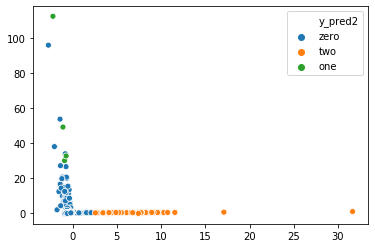

In [15]:
#Visualize with first 2 components of PCA

start_time = time.time()
pca_raw = PCA(n_components=2, random_state=42)
pca_data_raw = pca_raw.fit_transform(df_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(pca_data_raw[:,0], pca_data_raw[:,1], hue=predictions_3cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 35.60704255104065 seconds ---
--- 35.71674823760986 seconds ---


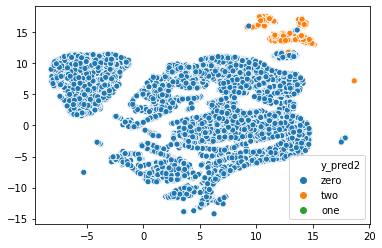

In [16]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_model_raw = umap.UMAP(n_neighbors=15,
                      min_dist=0.1,
                      metric='correlation', random_state=42)
umap_results_raw = umap_model_raw.fit_transform(df_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_3cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [17]:
#Perform K-Means on numerical variables with 6 clusters

start_time = time.time()
k_means_6cls = KMeans(n_clusters=6, random_state=42)
y_pred_6cls = k_means_6cls.fit_predict(df_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_6cls = pd.DataFrame(y_pred_6cls, columns=['y_pred'])
predictions_6cls['y_pred2'] = predictions_6cls['y_pred'].apply(lambda x: mapping(x))

for i in predictions_6cls['y_pred2'].unique():
    print(predictions_6cls['y_pred2'][(predictions_6cls['y_pred2'] == i)].count())

--- 0.5983991622924805 seconds ---
13537
8050
6041
1925
9
4


--- 0.13065242767333984 seconds ---


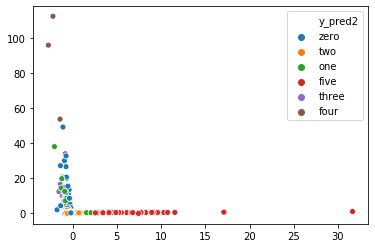

In [18]:
#Visualize with first 2 components of PCA

start_time = time.time()
sns.scatterplot(pca_data_raw[:,0], pca_data_raw[:,1], hue=predictions_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.12659955024719238 seconds ---


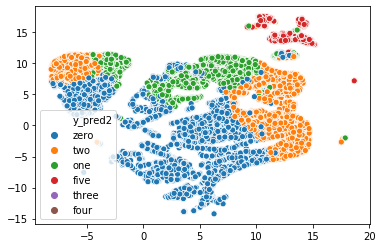

In [19]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

# Visualize numerical data with dimensionality reduction

In [20]:
#Perform PCA on numerical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
pca_dimred = PCA(n_components=6, random_state=42)
pca_data_dimred = pca_dimred.fit_transform(df_scaled)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
k_means_pcadimred_6cls = KMeans(n_clusters=6, random_state=42)
y_pred_pcadimred_6cls = k_means_pcadimred_6cls.fit_predict(pca_data_dimred)

print("--- %s seconds ---" % (time.time() - start_time))

predictions_pcadimred_6cls = pd.DataFrame(y_pred_pcadimred_6cls, columns=['y_pred'])
predictions_pcadimred_6cls['y_pred2'] = predictions_pcadimred_6cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_pcadimred_6cls['y_pred2'].unique():
    print(predictions_pcadimred_6cls['y_pred2'][(predictions_pcadimred_6cls['y_pred2'] == i)].count())

--- 0.05087423324584961 seconds ---
--- 1.011284589767456 seconds ---
15514
12067
1932
20
29
4


--- 0.11967897415161133 seconds ---


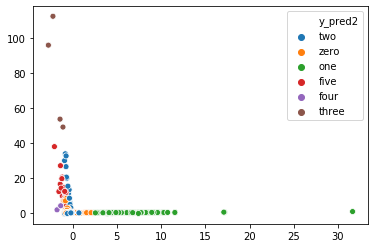

In [21]:
#Visualize with first 2 components of PCA

start_time = time.time()
sns.scatterplot(pca_data_raw[:,0], pca_data_raw[:,1], hue=predictions_pcadimred_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.12466597557067871 seconds ---


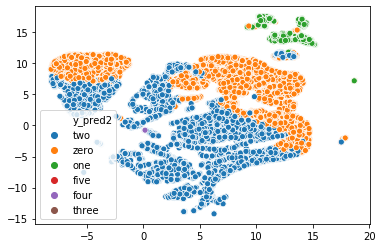

In [22]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_pcadimred_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [23]:
#Perform UMAP on numerical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
umap_results_dimred = umap_results_raw
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
k_means_umapdimred_6cls = KMeans(n_clusters=6, random_state=42)
y_pred_umapdimred_6cls = k_means_umapdimred_6cls.fit_predict(umap_results_dimred)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_umapdimred_6cls = pd.DataFrame(y_pred_umapdimred_6cls, columns=['y_pred'])
predictions_umapdimred_6cls['y_pred2'] = predictions_umapdimred_6cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_umapdimred_6cls['y_pred2'].unique():
    print(predictions_umapdimred_6cls['y_pred2'][(predictions_umapdimred_6cls['y_pred2'] == i)].count())

--- 0.0 seconds ---
--- 0.6712043285369873 seconds ---
5568
4843
5990
5482
5251
2432


--- 0.11669492721557617 seconds ---


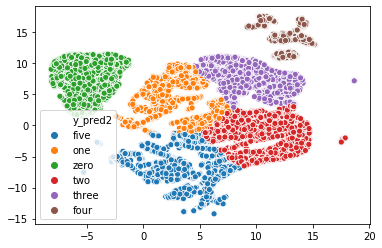

In [24]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_raw[:,0], umap_results_raw[:,1], hue=predictions_umapdimred_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

# Convert categorical data to numerical data with MCA

In [25]:
#Perform MCA on categorical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
mca = pn.MCA(n_components=10, n_iter=5, copy=True, check_input=True, engine='sklearn', random_state=123)
df_cat_mca_raw = mca.fit_transform(df_cat)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
k_means_mca_6cls = KMeans(n_clusters=6, random_state=42)
y_pred_mca_6cls = k_means_mca_6cls.fit_predict(df_cat_mca_raw)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_mca_6cls = pd.DataFrame(y_pred_mca_6cls, columns=['y_pred'])
predictions_mca_6cls['y_pred2'] = predictions_mca_6cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_mca_6cls['y_pred2'].unique():
    print(predictions_mca_6cls['y_pred2'][(predictions_mca_6cls['y_pred2'] == i)].count())

--- 1.7047224044799805 seconds ---
--- 0.24532532691955566 seconds ---
29555
7
1
1
1
1


--- 0.050864458084106445 seconds ---
--- 0.17552995681762695 seconds ---


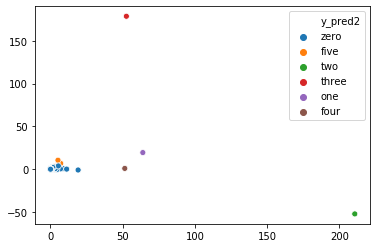

In [26]:
#Visualize with first 2 components of PCA

start_time = time.time()
pca_mca = PCA(n_components=2, random_state=42)
pca_data_mca = pca_mca.fit_transform(df_cat_mca_raw)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(pca_data_mca[:,0], pca_data_mca[:,1], hue=predictions_mca_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [27]:
#Scale categorical variables

df_cat_mca_scaled = scaler.fit_transform(df_cat_mca_raw)

In [28]:
df_new = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame(df_cat_mca_scaled)], axis=1)
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9
0,0.030899,-1.142158,-0.244393,-0.288453,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.026921,0.010593,0.003484,-0.000476,0.010372,0.005593,-0.018144,-0.002736,-0.012221,-0.020787
1,-0.124468,-0.607862,-0.244393,-0.529891,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.014445,-0.003351,-0.003057,-0.001678,-0.029200,-0.007844,0.025650,0.002670,0.017629,0.052600
2,0.186266,-0.073566,1.250338,0.194423,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.034424,0.016812,0.012055,0.011685,0.008352,0.016411,0.007558,-0.000185,0.010093,-0.010498
3,0.341633,-0.760518,-0.182112,-0.529891,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.031178,0.013497,0.011053,0.010447,0.012306,0.023424,0.022503,0.001509,0.028742,0.017454
4,0.807733,-0.607862,1.203627,1.039455,-0.258151,-0.225135,-0.015792,-0.016143,-0.040141,-0.033061,...,-0.032240,0.015030,0.011735,0.011607,0.006502,0.020571,0.017654,-0.000905,0.018659,-0.005641


# Visualize combined data

--- 0.0847768783569336 seconds ---
--- 0.1605687141418457 seconds ---


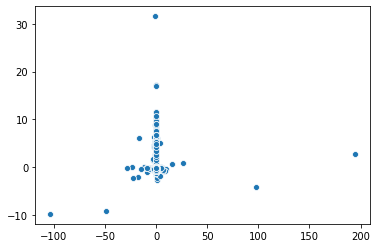

In [29]:
#Visualize with first 2 components of PCA

start_time = time.time()
pca_total = PCA(n_components=2, random_state=42)
pca_data_total = pca_total.fit_transform(df_new)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(pca_data_total[:,0], pca_data_total[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

--- 33.48259115219116 seconds ---
--- 33.55142903327942 seconds ---


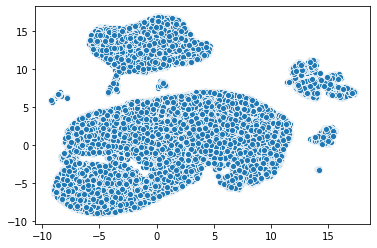

In [30]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_model_total = umap.UMAP(n_neighbors=30,
                                    n_components=2,
                                    min_dist=0.3,
                                    metric='correlation', random_state=143)
umap_results_total = umap_model_total.fit_transform(df_new)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

In [31]:
#Perform PCA on all variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
pca_total_dimred = PCA(n_components=6, random_state=42)
pca_data_total_dimred = pca_total_dimred.fit_transform(df_new)
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
k_means_pca_totaldimred_6cls = KMeans(n_clusters=6, random_state=42)
y_pred_pca_totaldimred_6cls = k_means_pca_totaldimred_6cls.fit_predict(pca_data_total_dimred)

print("--- %s seconds ---" % (time.time() - start_time))

predictions_pca_totaldimred_6cls = pd.DataFrame(y_pred_pca_totaldimred_6cls, columns=['y_pred'])
predictions_pca_totaldimred_6cls['y_pred2'] = predictions_pca_totaldimred_6cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_pca_totaldimred_6cls['y_pred2'].unique():
    print(predictions_pca_totaldimred_6cls['y_pred2'][(predictions_pca_totaldimred_6cls['y_pred2'] == i)].count())

--- 0.08476138114929199 seconds ---
--- 0.24534034729003906 seconds ---
27623
1939
1
1
1
1


--- 0.12667036056518555 seconds ---


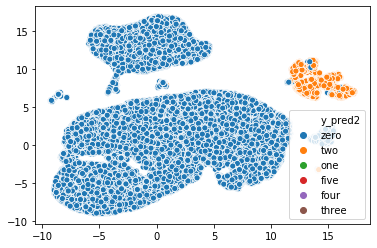

In [32]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_pca_totaldimred_6cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

# Clustering analysis

## K-means clustering

In [33]:
#Calculate silhouette score for various numbers of clusters with K-means

start_time = time.time()
for n in range(2, 10):
    k_means_umap_totaldimred_temp = KMeans(n_clusters=n, random_state=42)
    y_pred_umap_totaldimred_temp = k_means_umap_totaldimred_temp.fit_predict(umap_results_total)

    predictions_umap_totaldimred_temp = pd.DataFrame(y_pred_umap_totaldimred_temp, columns=['y_pred'])
    
    print('For {} clusters:'.format(n))
    print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_umap_totaldimred_temp['y_pred'], metric='euclidean')))
    print("--- %s seconds ---" % (time.time() - start_time))
    print()

For 2 clusters:
The silhouette score is 0.3806646168231964
--- 13.98655915260315 seconds ---

For 3 clusters:
The silhouette score is 0.49289804697036743
--- 27.877429246902466 seconds ---

For 4 clusters:
The silhouette score is 0.45586448907852173
--- 42.49440860748291 seconds ---

For 5 clusters:
The silhouette score is 0.44474467635154724
--- 57.00908803939819 seconds ---

For 6 clusters:
The silhouette score is 0.4519931972026825
--- 71.57721281051636 seconds ---

For 7 clusters:
The silhouette score is 0.4674398899078369
--- 86.40953993797302 seconds ---

For 8 clusters:
The silhouette score is 0.42735403776168823
--- 102.02078080177307 seconds ---

For 9 clusters:
The silhouette score is 0.4188203811645508
--- 117.43614292144775 seconds ---



In [34]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
k_means_umap_totaldimred_3cls = KMeans(n_clusters=3, random_state=3)
y_pred_umap_totaldimred_3cls = k_means_umap_totaldimred_3cls.fit_predict(umap_results_total)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_umap_totaldimred_3cls = pd.DataFrame(y_pred_umap_totaldimred_3cls, columns=['y_pred'])
predictions_umap_totaldimred_3cls['y_pred2'] = predictions_umap_totaldimred_3cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_umap_totaldimred_3cls['y_pred2'].unique():
    print(predictions_umap_totaldimred_3cls['y_pred2'][(predictions_umap_totaldimred_3cls['y_pred2'] == i)].count())

--- 0.3321115970611572 seconds ---
11830
10841
6895


--- 0.15957307815551758 seconds ---


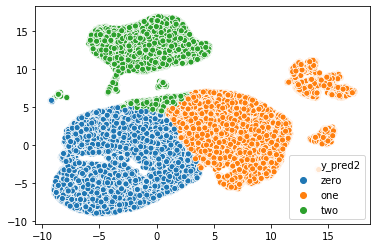

In [35]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_umap_totaldimred_3cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [36]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
k_means_umap_totaldimred_4cls = KMeans(n_clusters=4, random_state=3)
y_pred_umap_totaldimred_4cls = k_means_umap_totaldimred_4cls.fit_predict(umap_results_total)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_umap_totaldimred_4cls = pd.DataFrame(y_pred_umap_totaldimred_4cls, columns=['y_pred'])
predictions_umap_totaldimred_4cls['y_pred2'] = predictions_umap_totaldimred_4cls['y_pred'].apply(lambda x: mapping(x))
for i in predictions_umap_totaldimred_4cls['y_pred2'].unique():
    print(predictions_umap_totaldimred_4cls['y_pred2'][(predictions_umap_totaldimred_4cls['y_pred2'] == i)].count())

--- 0.7799122333526611 seconds ---
9854
9361
6555
3796


--- 0.16259407997131348 seconds ---


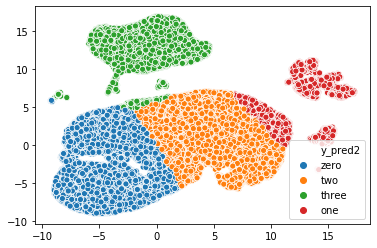

In [37]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_umap_totaldimred_4cls['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [38]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_umap_totaldimred_4cls['y_pred'], metric='euclidean')))

The silhouette score is 0.45553579926490784


## Hierarchical clustering

In [39]:
#Calculate silhouette score for various numbers of clusters with hierarchical clustering

start_time = time.time()
for n in range(2, 10):
    agg_cluster_temp = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=n,
                                              compute_full_tree=False)
    y_pred_hier_temp = agg_cluster_temp.fit_predict(umap_results_total)

    predictions_hier_temp = pd.DataFrame(y_pred_hier_temp, columns=['y_pred'])
    
    print('For {} clusters:'.format(n))
    print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_hier_temp['y_pred'], metric='euclidean')))
    print("--- %s seconds ---" % (time.time() - start_time))
    print()

For 2 clusters:
The silhouette score is 0.2996659278869629
--- 89.74928212165833 seconds ---

For 3 clusters:
The silhouette score is 0.2568907141685486
--- 169.52138829231262 seconds ---

For 4 clusters:
The silhouette score is 0.21031184494495392
--- 253.30955243110657 seconds ---

For 5 clusters:
The silhouette score is 0.28816547989845276
--- 309.05934143066406 seconds ---

For 6 clusters:
The silhouette score is 0.2206801027059555
--- 365.90748715400696 seconds ---

For 7 clusters:
The silhouette score is 0.21094143390655518
--- 444.36128282546997 seconds ---

For 8 clusters:
The silhouette score is 0.18174168467521667
--- 549.515825510025 seconds ---

For 9 clusters:
The silhouette score is 0.1942213773727417
--- 625.3669302463531 seconds ---



In [40]:
#Perform hierarchical clustering on resulting components with optimal number of clusters

start_time = time.time()
agg_cluster_2 = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

y_pred_hier_2 = agg_cluster_2.fit_predict(umap_results_total)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_hier_2 = pd.DataFrame(y_pred_hier_2, columns=['y_pred'])
predictions_hier_2['y_pred2'] = predictions_hier_2['y_pred'].apply(lambda x: mapping(x))
for i in predictions_hier_2['y_pred2'].unique():
    print(predictions_hier_2['y_pred2'][(predictions_hier_2['y_pred2'] == i)].count())

--- 72.78625202178955 seconds ---
10409
19157


--- 0.4194376468658447 seconds ---


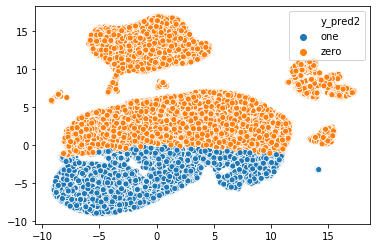

In [41]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_hier_2['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [42]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_hier_2['y_pred'], metric='euclidean')))

The silhouette score is 0.2996659278869629


## DBSCAN clustering

In [43]:
#Calculate silhouette score for various values of epsilon with DBSCAN

start_time = time.time()
for i in range(1, 4):
    dbscan_cluster_temp = DBSCAN(eps=i, min_samples=5)

    y_pred_dbscan_temp = dbscan_cluster_temp.fit_predict(umap_results_total)

    predictions_dbscan_temp = pd.DataFrame(y_pred_dbscan_temp, columns=['y_pred'])
    
    print('For an epsilon of {}'.format(i))
    print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_dbscan_temp['y_pred'], metric='euclidean')))
    print("--- %s seconds ---" % (time.time() - start_time))
    print()

For an epsilon of 1
The silhouette score is 0.06950618326663971
--- 18.754855632781982 seconds ---

For an epsilon of 2
The silhouette score is -0.03818388655781746
--- 38.87677192687988 seconds ---

For an epsilon of 3
The silhouette score is 0.20167815685272217
--- 60.11928629875183 seconds ---



In [44]:
#Perform DBSCAN on resulting components with optimal epsilon

start_time = time.time()
dbscan_cluster = DBSCAN(eps=3, min_samples=5)

y_pred_dbscan = dbscan_cluster.fit_predict(umap_results_total)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_dbscan = pd.DataFrame(y_pred_dbscan, columns=['y_pred'])
predictions_dbscan['y_pred2'] = predictions_dbscan['y_pred'].apply(lambda x: mapping(x))
for i in predictions_dbscan['y_pred2'].unique():
    print(predictions_dbscan['y_pred2'][(predictions_dbscan['y_pred2'] == i)].count())

--- 2.1801676750183105 seconds ---
27515
2002
49


--- 0.1436164379119873 seconds ---


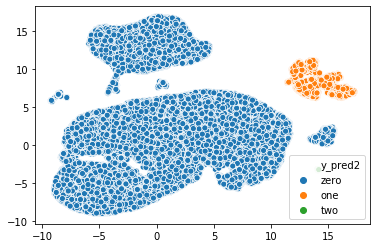

In [45]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total[:,0], umap_results_total[:,1], hue=predictions_dbscan['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [46]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_results_total, predictions_dbscan['y_pred'], metric='euclidean')))

The silhouette score is 0.20167815685272217


### K-means clustering with 4 clusters determined to be optimal clustering method

# Repeat analysis with larger subsample of data

In [47]:
#Sample data

df_clean_final = df_clean.sample(frac=0.3, random_state=123).reset_index()

df_num_final = df_clean_final[['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT']].copy()
df_cat_final = df_clean_final.drop(['CONTACT_HOUR', 'AGE', 'HEIGHT', 'WEIGHT', 'DISPERSAL_TIME', 'NUMBER_OF_PERSONS_DISPERSED', 
                  'COCAINE_AMOUNT', 'HEROIN_AMOUNT', 'CANNABIS_AMOUNT', 'SEARCH_COCAINE_AMOUNT', 'SEARCH_HEROIN_AMOUNT', 
                  'SEARCH_CANNABIS_AMOUNT'], axis=1)

In [48]:
#Scale numerical variables

scaler = StandardScaler()
df_scaled_final = scaler.fit_transform(df_num_final)

In [49]:
#Perform MCA on categorical variables for dimensionality reduction, perform K-Means on resulting components

start_time = time.time()
df_cat_mca_final = mca.fit_transform(df_cat_final)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.878744125366211 seconds ---


In [50]:
#Scale categorical variables and combine with numerical variables

df_cat_mca_scaled_final = scaler.fit_transform(df_cat_mca_final)

df_combined_final = pd.concat([pd.DataFrame(df_scaled_final), pd.DataFrame(df_cat_mca_scaled_final)], axis=1)

--- 146.49582028388977 seconds ---
--- 146.70529103279114 seconds ---


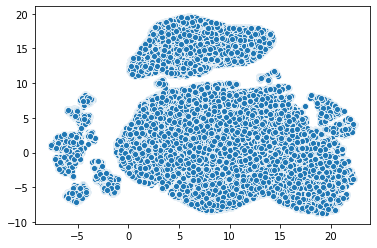

In [51]:
#Visualize with first 2 components of UMAP

start_time = time.time()
umap_results_total_final = umap_model_total.fit_transform(df_combined_final)
print("--- %s seconds ---" % (time.time() - start_time))

sns.scatterplot(umap_results_total_final[:,0], umap_results_total_final[:,1])
print("--- %s seconds ---" % (time.time() - start_time))

In [52]:
#Perform K-Means on resulting components with optimal number of clusters

start_time = time.time()
y_pred_umap_final = k_means_umap_totaldimred_4cls.fit_predict(umap_results_total_final)
print("--- %s seconds ---" % (time.time() - start_time))

predictions_umap_final = pd.DataFrame(y_pred_umap_final, columns=['y_pred'])
predictions_umap_final['y_pred2'] = predictions_umap_final['y_pred'].apply(lambda x: mapping(x))
for i in predictions_umap_final['y_pred2'].unique():
    print(predictions_umap_final['y_pred2'][(predictions_umap_final['y_pred2'] == i)].count())

--- 2.054699182510376 seconds ---
27060
18841
23255
19541


--- 0.4707479476928711 seconds ---


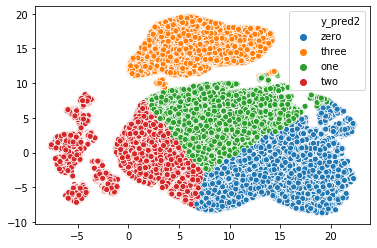

In [53]:
#Visualize with first 2 components of UMAP

start_time = time.time()
sns.scatterplot(umap_results_total_final[:,0], umap_results_total_final[:,1], hue=predictions_umap_final['y_pred2'])
print("--- %s seconds ---" % (time.time() - start_time))

In [54]:
#Calculate silhouette score

print('The silhouette score is {}'.format(silhouette_score(umap_results_total_final, predictions_umap_final['y_pred'], metric='euclidean')))

The silhouette score is 0.394226610660553


# Analyze clusters

In [55]:
df_clean_final['Cluster'] = predictions_umap_final['y_pred']

In [56]:
categorical = list(df_clean_final.select_dtypes(include='object').columns)
categorical.append('AREA')
categorical.append('RES_AREA')
categorical.append('BUS_AREA')

df_clean_final_ = pd.get_dummies(data=df_clean_final, columns=categorical)

In [57]:
df_clean_0 = df_clean_final_[(df_clean_final_['Cluster'] == 0)]
df_clean_1 = df_clean_final_[(df_clean_final_['Cluster'] == 1)]
df_clean_2 = df_clean_final_[(df_clean_final_['Cluster'] == 2)]
df_clean_3 = df_clean_final_[(df_clean_final_['Cluster'] == 3)]

In [58]:
df_clean_0.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,...,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000,27060.000000
mean,87736.575721,19.529120,0.364006,30.174316,507.366851,151.968995,0.018699,0.387361,0.347746,0.000517,...,0.275499,0.345713,0.153400,0.318662,0.240207,0.287731,0.995048,0.002217,0.000887,0.001848
std,49052.714210,2.540671,0.481159,11.557108,6.907773,20.214001,0.135463,0.487156,23.700901,0.036471,...,0.446774,0.475609,0.360379,0.465966,0.427217,0.452713,0.070197,0.047037,0.029769,0.042946
min,5.000000,0.000000,0.000000,18.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47119.500000,18.000000,0.000000,21.000000,506.000000,140.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,85852.500000,20.000000,0.000000,26.000000,507.000000,150.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,123952.750000,22.000000,1.000000,37.000000,509.000000,165.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,188469.000000,23.000000,1.000000,75.000000,605.000000,309.000000,1.000000,1.000000,1930.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [59]:
df_clean_1.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,...,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000,23255.000000
mean,88334.270264,11.365900,0.378585,27.688798,507.933348,181.957084,0.020039,0.399570,0.000043,0.000043,...,0.260202,0.376865,0.164094,0.306773,0.228596,0.300538,0.991701,0.003655,0.001290,0.003354
std,47829.720868,6.892731,0.485045,8.912118,5.394255,44.793850,0.140136,0.489821,0.006558,0.006558,...,0.438754,0.484611,0.370369,0.461164,0.419937,0.458502,0.090724,0.060348,0.035895,0.057819
min,106.000000,0.000000,0.000000,18.000000,410.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48842.500000,6.000000,0.000000,21.000000,506.000000,150.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,86705.000000,12.000000,0.000000,25.000000,508.000000,180.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,123257.500000,17.000000,1.000000,31.000000,510.000000,205.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,188472.000000,23.000000,1.000000,116.000000,605.000000,699.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [60]:
df_clean_2.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,...,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000,19541.000000
mean,86254.941712,12.292513,0.372652,42.983368,489.779643,169.665677,0.009928,0.131928,489.823550,0.735530,...,0.229006,0.398342,0.125582,0.316514,0.218361,0.339543,0.994473,0.002047,0.000768,0.002712
std,46475.989555,5.585311,0.483523,13.941355,103.437722,48.401472,0.099145,0.338421,790.495885,1.387162,...,0.420204,0.489569,0.331386,0.465128,0.413145,0.473566,0.074139,0.045198,0.027696,0.052010
min,428.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47847.000000,10.000000,0.000000,34.000000,506.000000,150.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,83215.000000,13.000000,0.000000,45.000000,508.000000,165.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,120459.000000,16.000000,1.000000,54.000000,510.000000,185.000000,0.000000,0.000000,1200.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,188471.000000,23.000000,1.000000,130.000000,609.000000,999.000000,1.000000,1.000000,2359.000000,30.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [61]:
df_clean_3.describe()

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
count,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,...,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000,18841.000000
mean,89772.761053,14.824266,0.409851,33.448862,599.181678,192.654583,0.021867,0.352158,0.084231,0.000318,...,0.293297,0.369619,0.167772,0.279603,0.261026,0.291598,0.991932,0.004246,0.001115,0.002707
std,48633.940720,6.396544,0.491819,13.027252,15.522214,39.990297,0.146254,0.477655,9.206205,0.017843,...,0.455285,0.482714,0.373674,0.448816,0.439206,0.454510,0.089459,0.065025,0.033368,0.051958
min,614.000000,0.000000,0.000000,18.000000,411.000000,16.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49420.000000,11.000000,0.000000,23.000000,600.000000,165.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,87716.000000,16.000000,0.000000,29.000000,601.000000,185.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,125510.000000,20.000000,1.000000,42.000000,602.000000,210.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,188467.000000,23.000000,1.000000,126.000000,901.000000,900.000000,1.000000,1.000000,1252.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [62]:
for col in df_clean_final_.select_dtypes(exclude='object').columns:
    print(col)
    print(stats.f_oneway(df_clean_0[col], df_clean_1[col], df_clean_2[col], df_clean_3[col]))
    print('___________________________')

index
F_onewayResult(statistic=17.76015493482271, pvalue=1.6098969647427167e-11)
___________________________
CONTACT_HOUR
F_onewayResult(statistic=11140.561287746239, pvalue=0.0)
___________________________
NAME_VERIFIED_I
F_onewayResult(statistic=35.129382435695106, pvalue=1.1116946271381357e-22)
___________________________
AGE
F_onewayResult(statistic=6700.983699562012, pvalue=0.0)
___________________________
HEIGHT
F_onewayResult(statistic=19584.370912225855, pvalue=0.0)
___________________________
WEIGHT
F_onewayResult(statistic=4711.651060084083, pvalue=0.0)
___________________________
HANDCUFFED_I
F_onewayResult(statistic=31.71824022963531, pvalue=1.7535218583291078e-20)
___________________________
VEHICLE_INVOLVED_I
F_onewayResult(statistic=1557.5165288398807, pvalue=0.0)
___________________________
DISPERSAL_TIME
F_onewayResult(statistic=8833.086353316632, pvalue=0.0)
___________________________
NUMBER_OF_PERSONS_DISPERSED
F_onewayResult(statistic=6468.497807795815, pvalue=0.0)

F_onewayResult(statistic=1.2791772218068143, pvalue=0.2795576890882752)
___________________________
HAIR_COLOR_CODE_CD_PNK
F_onewayResult(statistic=3.836026049812436, pvalue=0.009276002151440083)
___________________________
HAIR_COLOR_CODE_CD_RED
F_onewayResult(statistic=16.506486723438478, pvalue=1.0179246151839644e-10)
___________________________
HAIR_COLOR_CODE_CD_SDY
F_onewayResult(statistic=2.350440205203759, pvalue=0.07028737508024135)
___________________________
HAIR_COLOR_CODE_CD_WHI
F_onewayResult(statistic=25.318538904022677, pvalue=2.296954345392137e-16)
___________________________
HAIR_COLOR_CODE_CD_XXX
F_onewayResult(statistic=63.66283344817684, pvalue=4.1323728915267243e-41)
___________________________
HAIR_STYLE_CODE_CD_AFRO
F_onewayResult(statistic=21.483416834028272, pvalue=6.650812982079113e-14)
___________________________
HAIR_STYLE_CODE_CD_BACK
F_onewayResult(statistic=0.5697966467374959, pvalue=0.634849735562095)
___________________________
HAIR_STYLE_CODE_CD_BALD


F_onewayResult(statistic=12.205088945118092, pvalue=5.569688553768828e-08)
___________________________
MAKE_CD_MOCA
F_onewayResult(statistic=2.471923480695899, pvalue=0.05976977495717918)
___________________________
MAKE_CD_MURM
F_onewayResult(statistic=0.7592571828768854, pvalue=0.5167958211888742)
___________________________
MAKE_CD_MUST
F_onewayResult(statistic=0.8806012868448774, pvalue=0.4502121092726692)
___________________________
MAKE_CD_MVEN
F_onewayResult(statistic=0.9380328651553181, pvalue=0.4211890089697732)
___________________________
MAKE_CD_NISS
F_onewayResult(statistic=93.09044197856485, pvalue=3.785277734569392e-60)
___________________________
MAKE_CD_ODSS
F_onewayResult(statistic=1.1796806763458356, pvalue=0.31574016997361143)
___________________________
MAKE_CD_OLDS
F_onewayResult(statistic=22.769270259475356, pvalue=9.956156130053017e-15)
___________________________
MAKE_CD_OPEL
F_onewayResult(statistic=0.7592571828768859, pvalue=0.5167958211888742)
_______________

F_onewayResult(statistic=4.659355469949387, pvalue=0.002936567137652752)
___________________________
COLOR_TOP_PNK
F_onewayResult(statistic=1.5185704864709604, pvalue=0.20738242998326717)
___________________________
COLOR_TOP_RED
F_onewayResult(statistic=76.68404733931501, pvalue=1.5619142972218034e-49)
___________________________
COLOR_TOP_RST
F_onewayResult(statistic=1.1147806122897443, pvalue=0.3415246730181612)
___________________________
COLOR_TOP_SIL
F_onewayResult(statistic=96.96664518340548, pvalue=1.174455256073868e-62)
___________________________
COLOR_TOP_TAN
F_onewayResult(statistic=54.4288905070489, pvalue=3.8548198823312395e-35)
___________________________
COLOR_TOP_TEA
F_onewayResult(statistic=0.02752921608212348, pvalue=0.9938417121795202)
___________________________
COLOR_TOP_TRQ
F_onewayResult(statistic=2.4358410094831013, pvalue=0.06272307363094692)
___________________________
COLOR_TOP_WHI
F_onewayResult(statistic=142.9508264742627, pvalue=2.0813382608249565e-92)
__

In [63]:
results = pd.DataFrame()
results['Comp'] = ['0vs1', '0vs2', '0vs3', '1vs2', '1vs3', '2vs3']
p_values = pd.DataFrame()
p_values['Comp'] = ['0vs1', '0vs2', '0vs3', '1vs2', '1vs3', '2vs3']

for col in df_clean_final_.select_dtypes(exclude='object').columns:
    tukey = pairwise_tukeyhsd(endog = df_clean_final_[col],
                          groups = df_clean_final_['Cluster'],
                          alpha=0.001)
    results[col] = tukey.reject
    p_values[col] = tukey.pvalues

In [64]:
results.head(6)

,Comp,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
0,0vs1,False,True,False,True,False,True,False,False,False,...,True,True,False,False,False,False,True,False,False,False
1,0vs2,False,True,False,True,True,True,True,True,True,...,True,True,True,False,True,True,False,False,False,False
2,0vs3,True,True,True,True,True,True,False,True,False,...,True,True,True,True,True,False,True,True,False,False
3,1vs2,True,True,False,True,True,True,True,True,True,...,True,True,True,False,False,True,False,False,False,False
4,1vs3,False,True,True,True,True,True,False,True,False,...,True,False,False,True,True,False,False,False,False,False
5,2vs3,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,False,True,False,False


In [65]:
p_values.head(6)

,Comp,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
0,0vs1,0.504894,0.001,0.004310,0.001,0.563851,0.001,0.648739,0.014987,0.900,...,0.001,0.001000,0.004919,0.020463,0.012019,0.009838,0.001000,0.016957,0.489669,0.005377
1,0vs2,0.005687,0.001,0.228488,0.001,0.001000,0.001,0.001000,0.001000,0.001,...,0.001,0.001000,0.001000,0.900000,0.001000,0.001000,0.861158,0.900000,0.900000,0.271986
2,0vs3,0.001000,0.001,0.001000,0.001,0.001000,0.001,0.055871,0.001000,0.900,...,0.001,0.001000,0.001000,0.001000,0.001000,0.787049,0.001000,0.001000,0.862127,0.286697
3,1vs2,0.001000,0.001,0.577580,0.001,0.001000,0.001,0.001000,0.001000,0.001,...,0.001,0.001000,0.001000,0.129246,0.062741,0.001000,0.002403,0.012801,0.328547,0.558257
4,1vs3,0.012187,0.001,0.001000,0.001,0.001000,0.001,0.492135,0.001000,0.900,...,0.001,0.419831,0.699634,0.001000,0.001000,0.193322,0.900000,0.665061,0.900000,0.559450
5,2vs3,0.001000,0.001,0.001000,0.001,0.001000,0.001,0.001000,0.001000,0.001,...,0.001,0.001000,0.001000,0.001000,0.001000,0.001000,0.011531,0.001000,0.686041,0.900000


In [66]:
results.replace(to_replace=True, value=1, inplace=True)
results.replace(to_replace=False, value=0, inplace=True)

In [67]:
results_significant = results.copy()
results_significant.drop(['index', 'Comp', 'Cluster'], axis=1, inplace=True)

for col in results_significant.columns:   
    if results_significant[col].sum() == 0:
        results_significant.drop(col, axis=1, inplace=True)
        
sig_features = list(results_significant.columns)

In [71]:
df_clean_final_

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
0,64975,15,0,18.0,507.0,160.0,0,0,0.0,0.0,...,0,1,0,0,0,1,1,0,0,0
1,26525,14,0,25.0,507.0,150.0,0,1,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
2,179568,16,0,32.0,603.0,180.0,0,0,0.0,0.0,...,0,0,0,0,0,1,1,0,0,0
3,130021,17,1,23.0,511.0,150.0,0,1,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
4,174627,20,0,25.0,600.0,215.0,0,1,0.0,0.0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88692,65909,9,0,26.0,600.0,200.0,0,0,2106.0,4.0,...,0,1,0,0,0,1,1,0,0,0
88693,164569,18,0,32.0,600.0,220.0,0,0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
88694,73427,11,1,60.0,601.0,160.0,0,0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0
88695,10431,21,0,55.0,601.0,185.0,0,0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0


In [73]:
cluster_means = df_clean_final_.groupby(['Cluster']).mean()
cluster_means

,index,CONTACT_HOUR,NAME_VERIFIED_I,AGE,HEIGHT,WEIGHT,HANDCUFFED_I,VEHICLE_INVOLVED_I,DISPERSAL_TIME,NUMBER_OF_PERSONS_DISPERSED,...,AREA_2,AREA_3,RES_AREA_0,RES_AREA_1,RES_AREA_2,RES_AREA_3,BUS_AREA_0,BUS_AREA_1,BUS_AREA_2,BUS_AREA_3
Cluster,,,,,,,,,,,,,,,,,,,,,
0,87736.575721,19.529120,0.364006,30.174316,507.366851,151.968995,0.018699,0.387361,0.347746,0.000517,...,0.275499,0.345713,0.153400,0.318662,0.240207,0.287731,0.995048,0.002217,0.000887,0.001848
1,88334.270264,11.365900,0.378585,27.688798,507.933348,181.957084,0.020039,0.399570,0.000043,0.000043,...,0.260202,0.376865,0.164094,0.306773,0.228596,0.300538,0.991701,0.003655,0.001290,0.003354
2,86254.941712,12.292513,0.372652,42.983368,489.779643,169.665677,0.009928,0.131928,489.823550,0.735530,...,0.229006,0.398342,0.125582,0.316514,0.218361,0.339543,0.994473,0.002047,0.000768,0.002712
3,89772.761053,14.824266,0.409851,33.448862,599.181678,192.654583,0.021867,0.352158,0.084231,0.000318,...,0.293297,0.369619,0.167772,0.279603,0.261026,0.291598,0.991932,0.004246,0.001115,0.002707


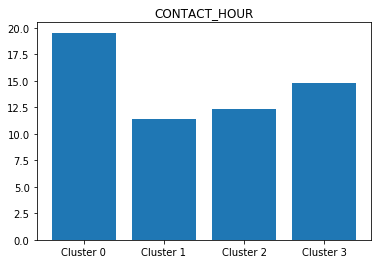

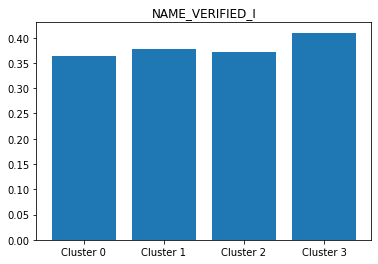

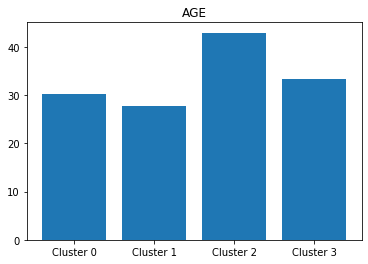

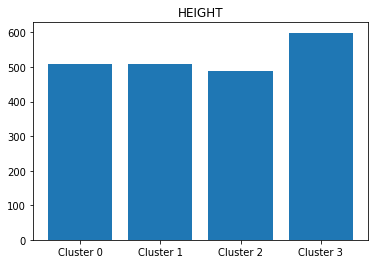

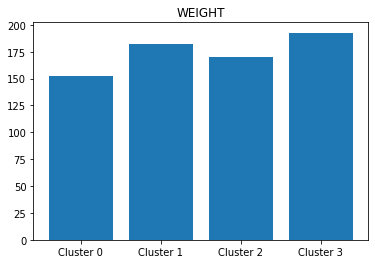

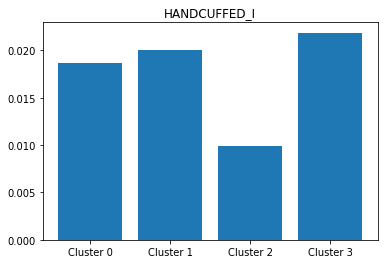

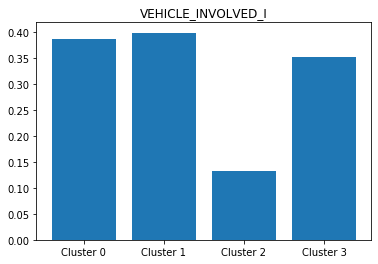

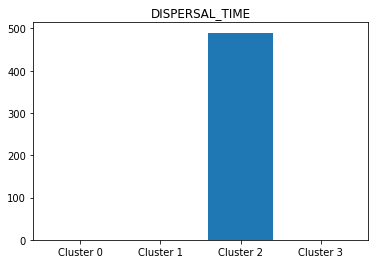

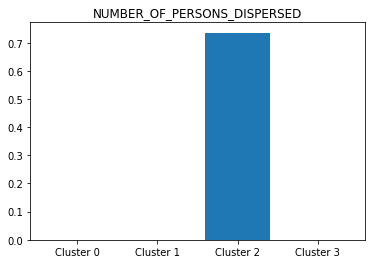

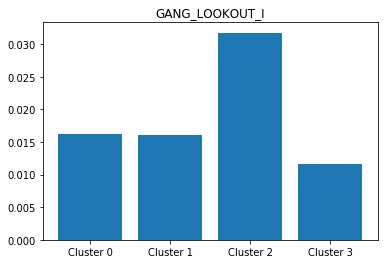

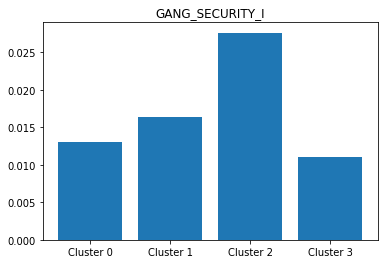

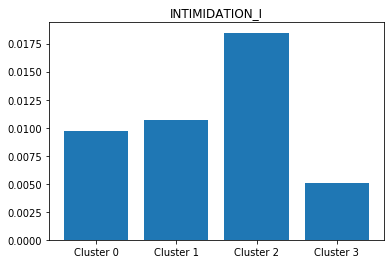

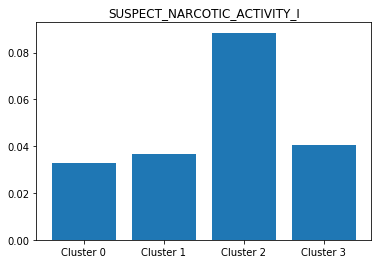

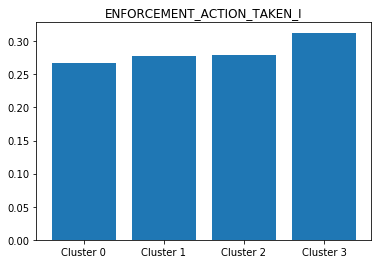

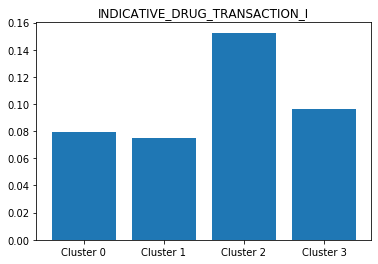

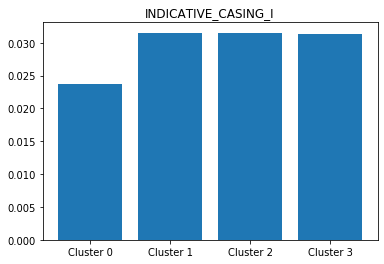

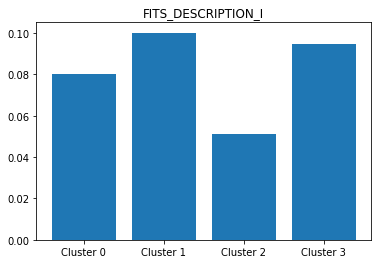

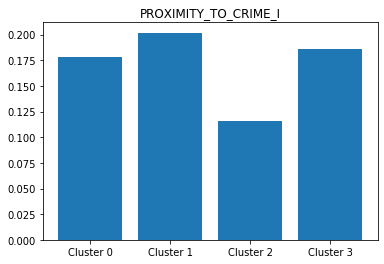

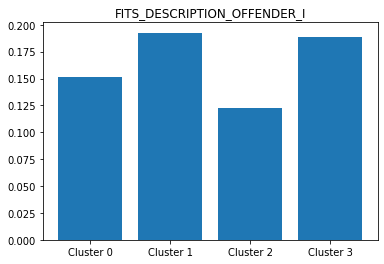

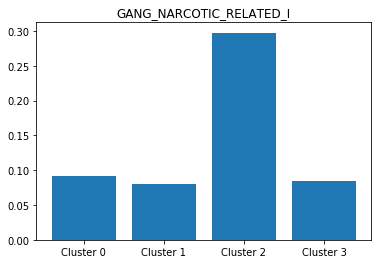

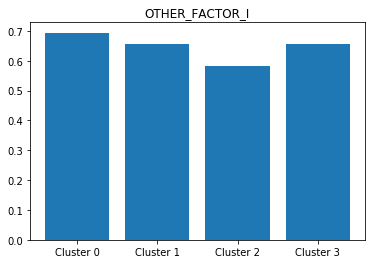

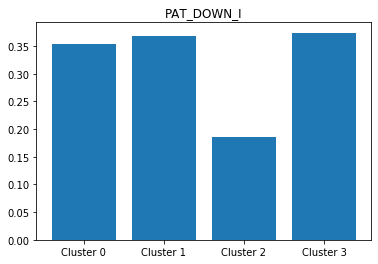

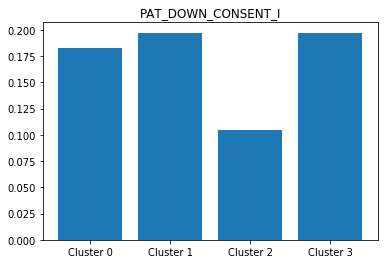

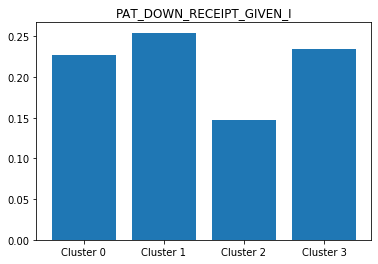

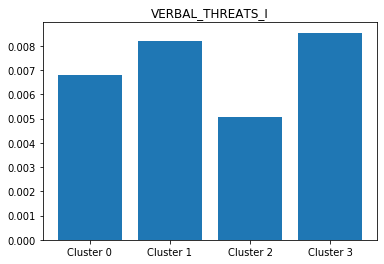

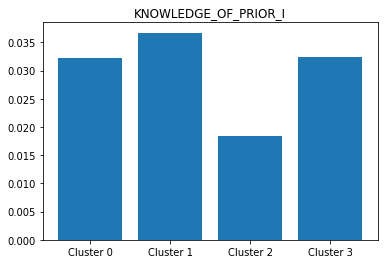

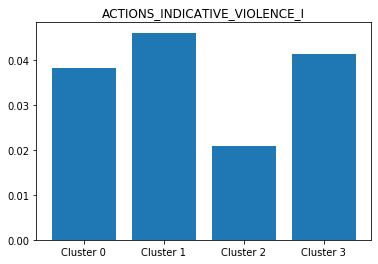

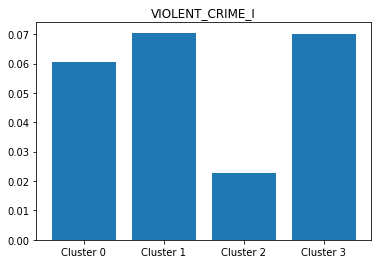

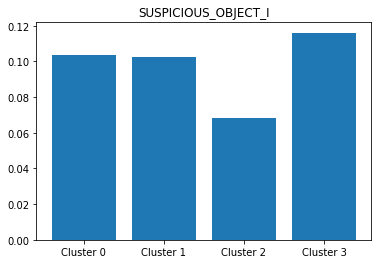

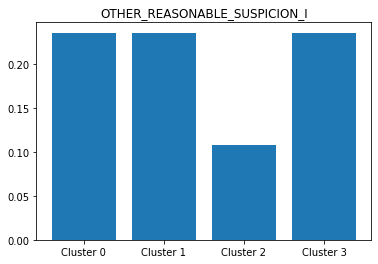

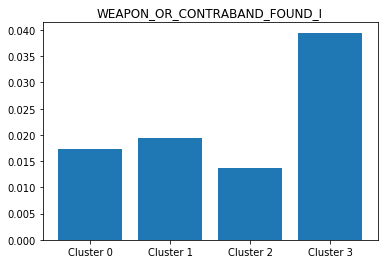

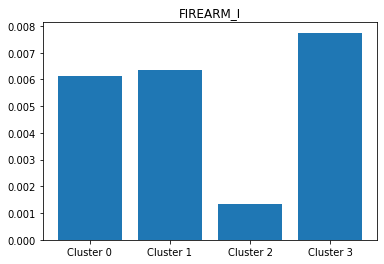

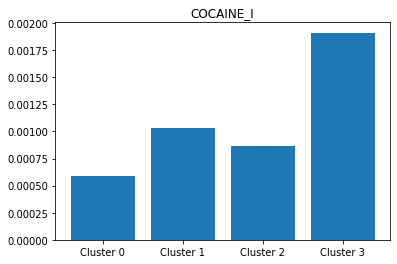

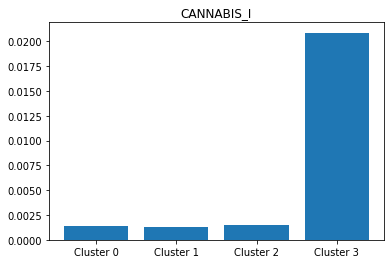

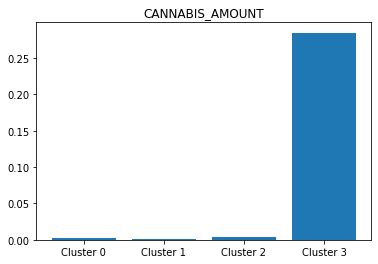

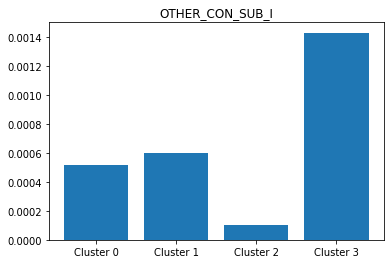

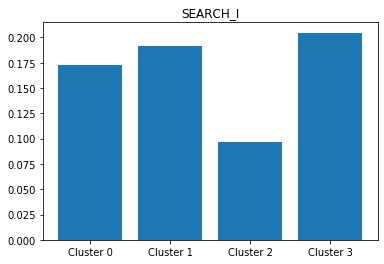

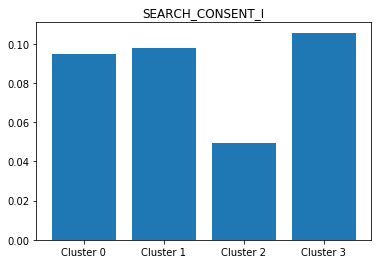

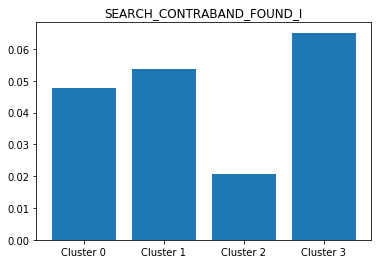

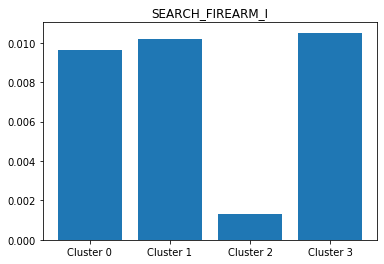

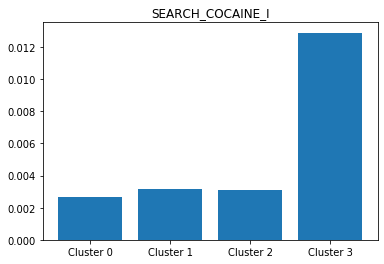

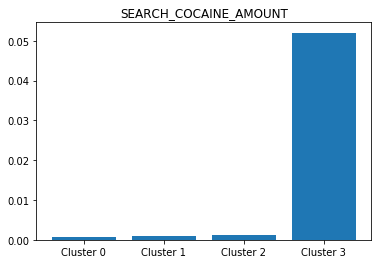

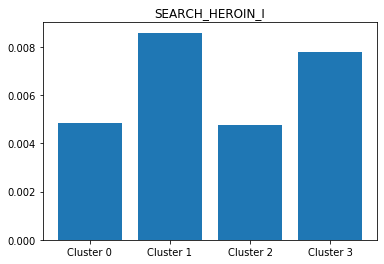

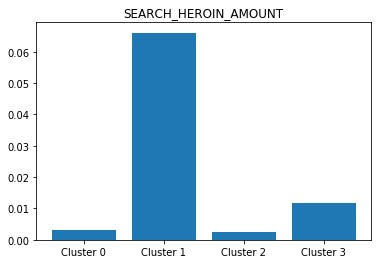

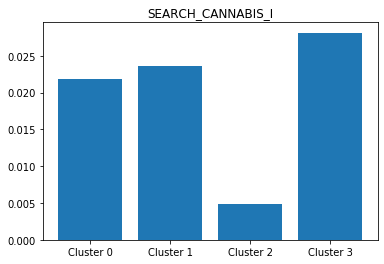

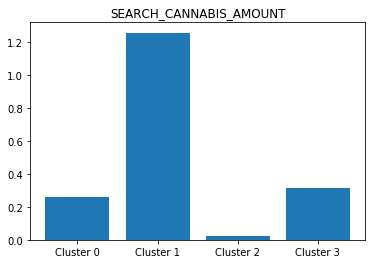

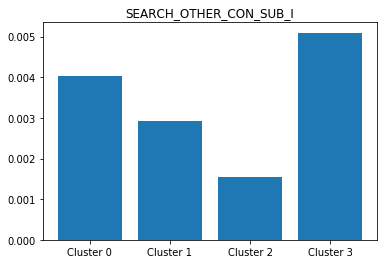

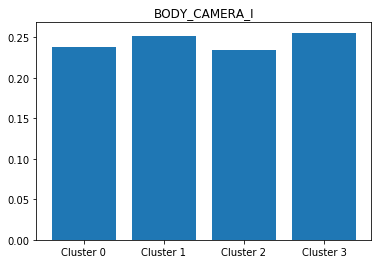

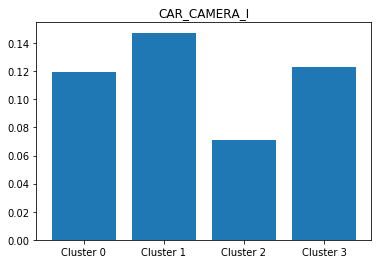

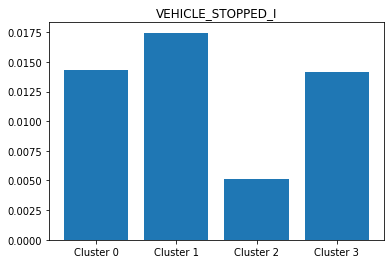

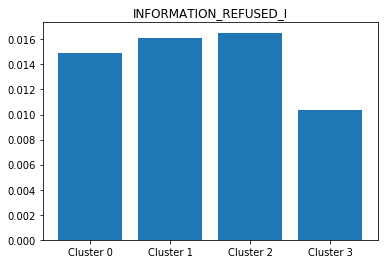

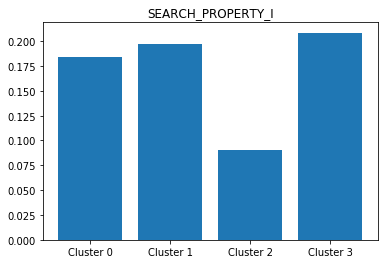

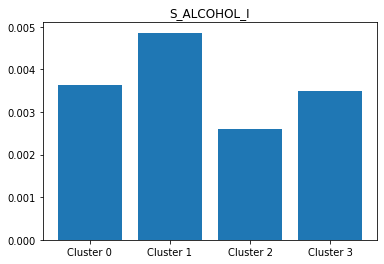

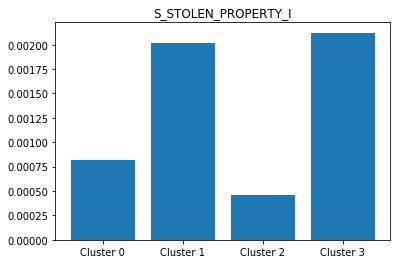

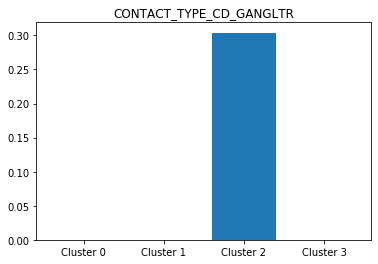

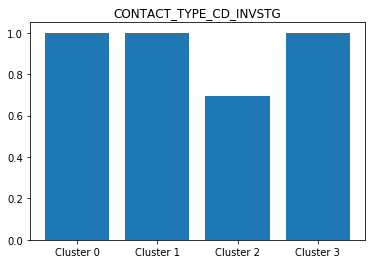

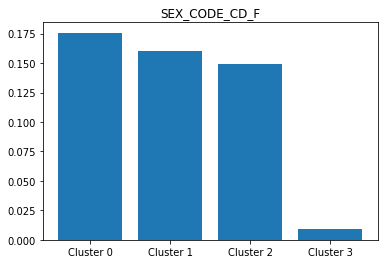

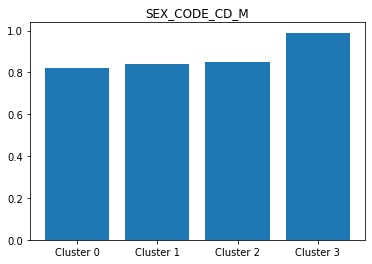

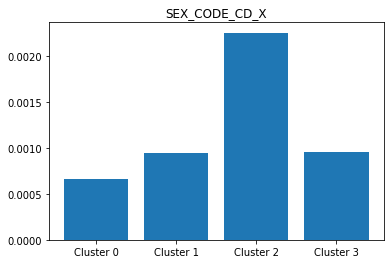

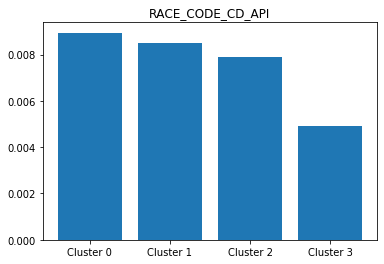

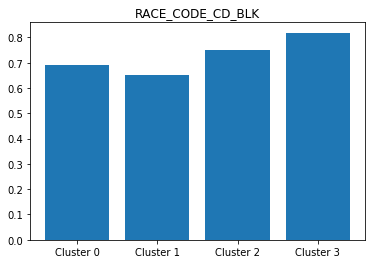

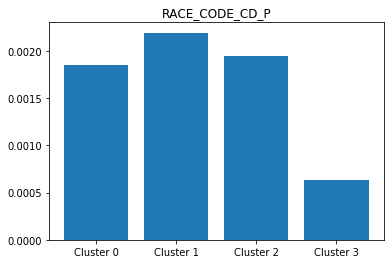

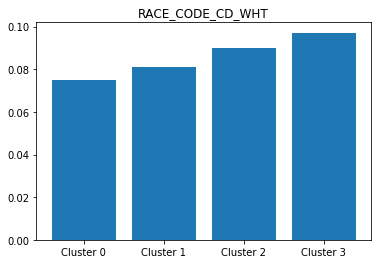

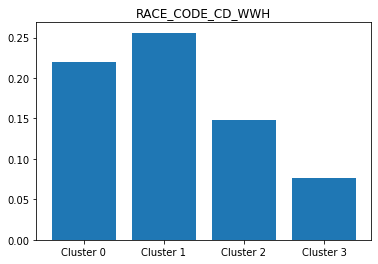

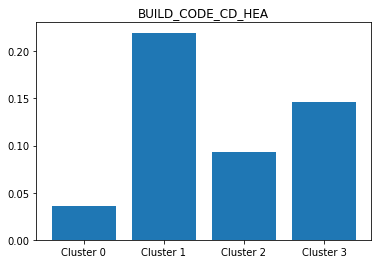

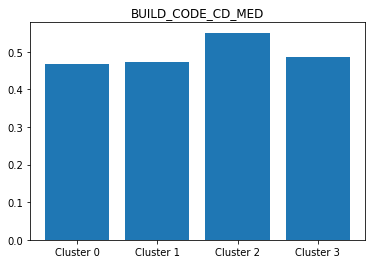

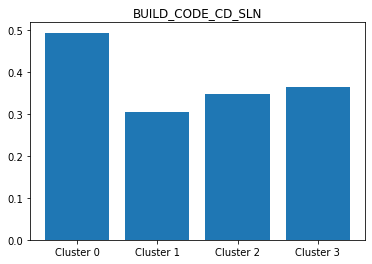

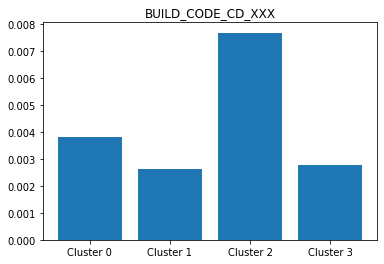

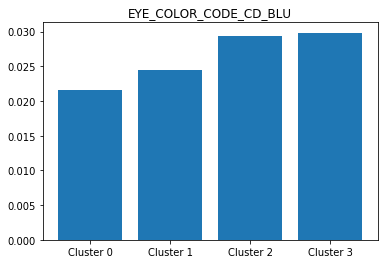

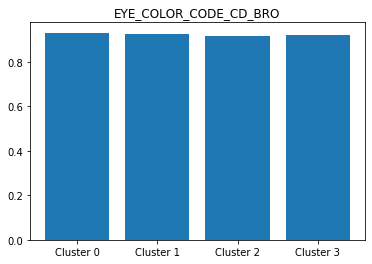

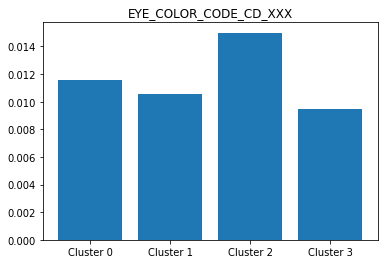

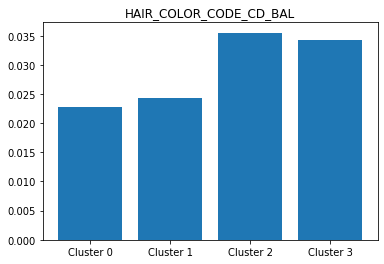

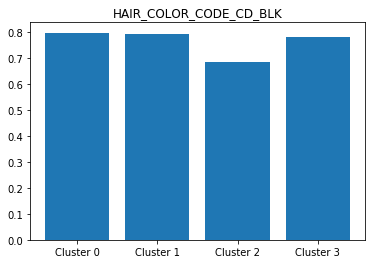

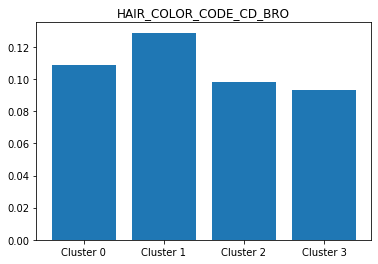

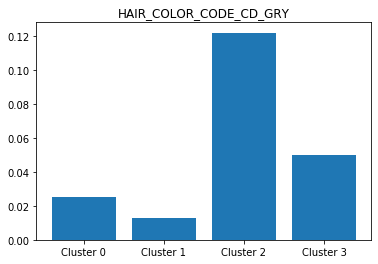

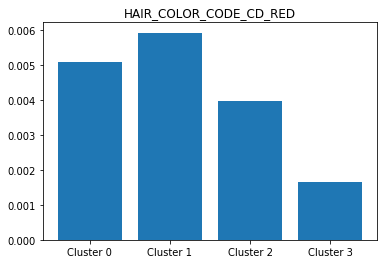

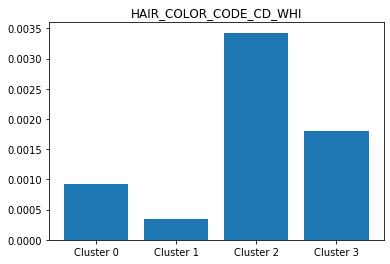

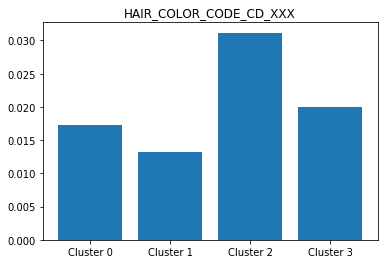

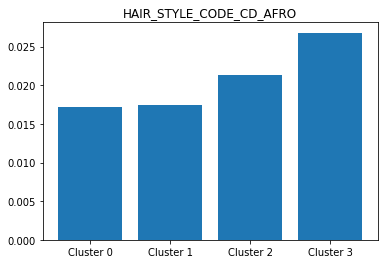

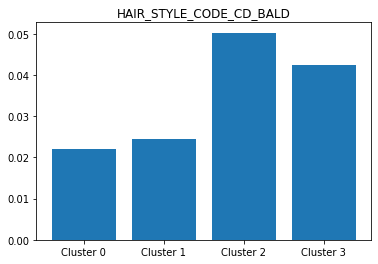

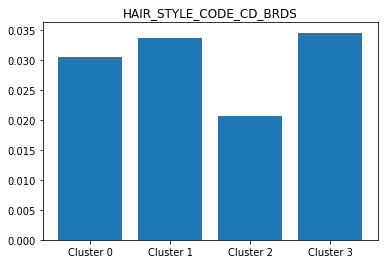

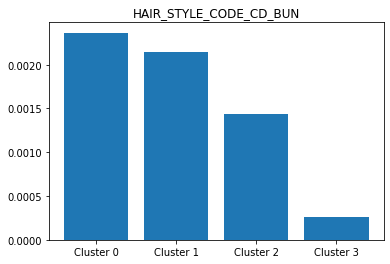

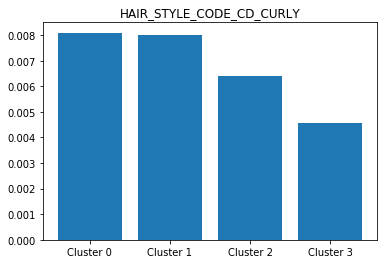

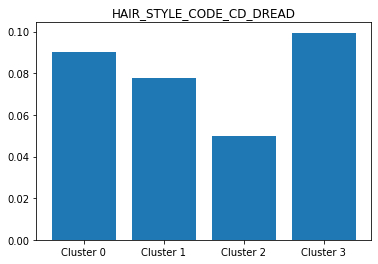

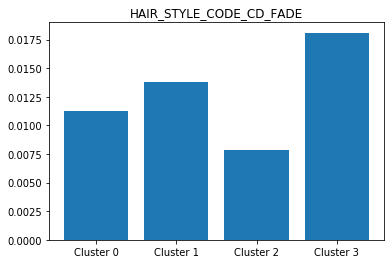

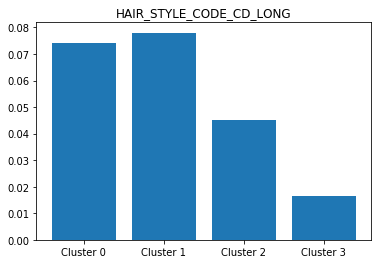

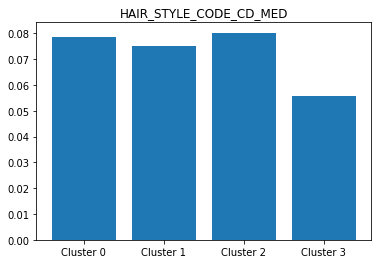

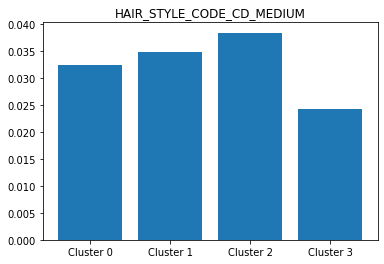

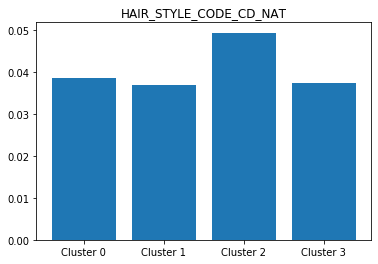

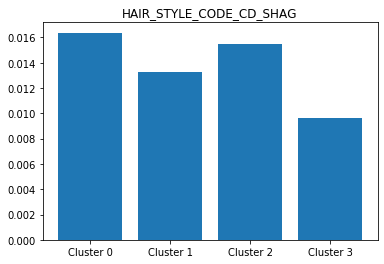

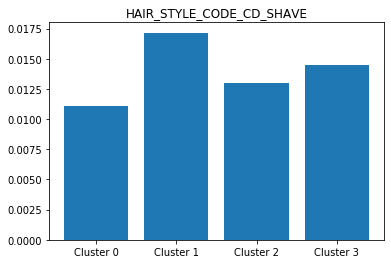

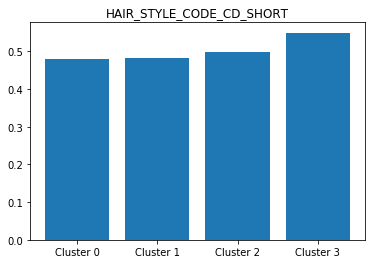

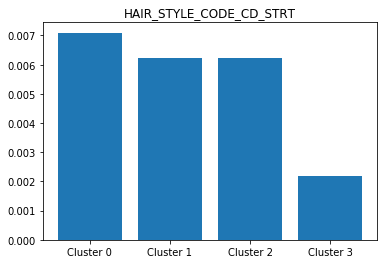

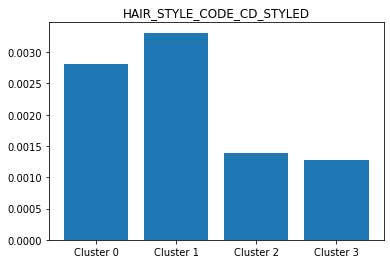

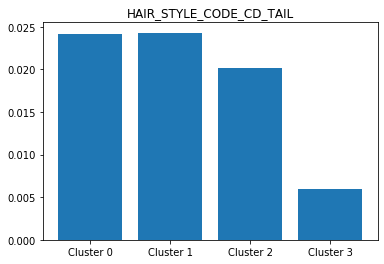

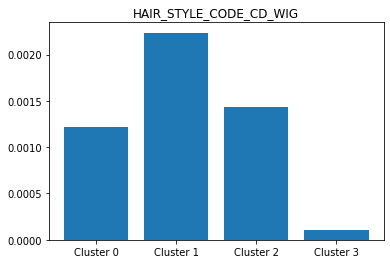

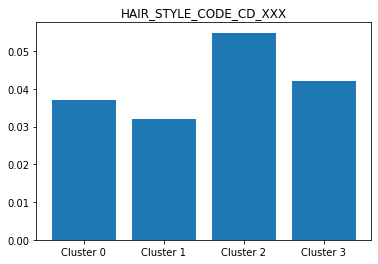

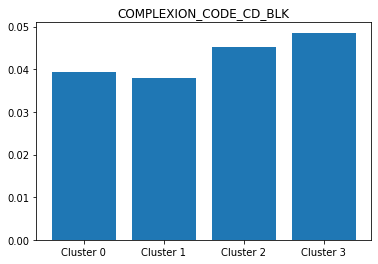

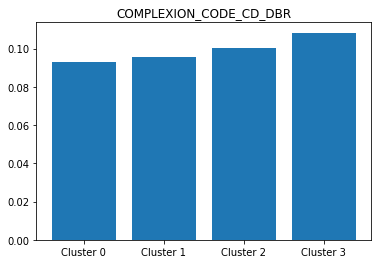

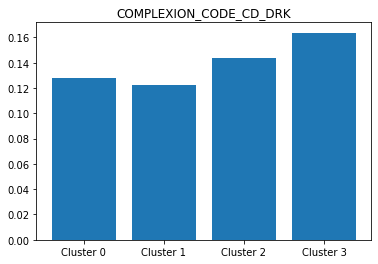

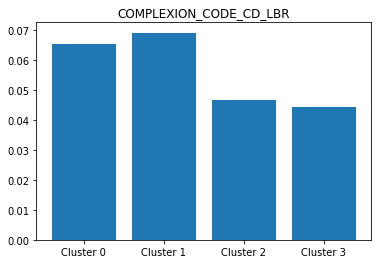

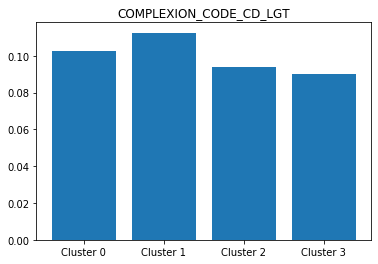

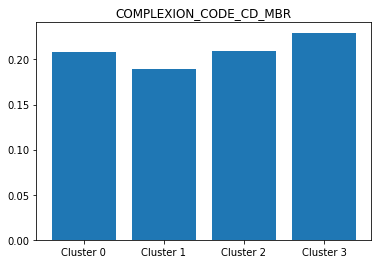

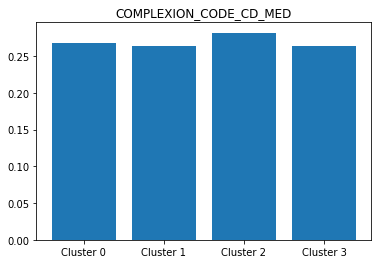

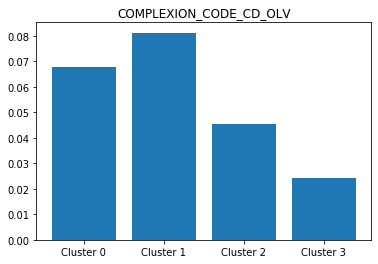

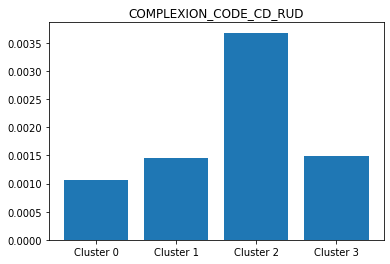

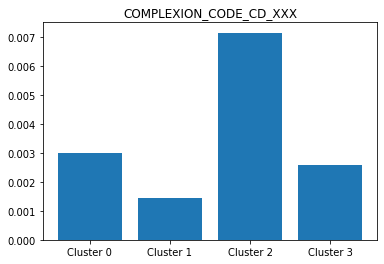

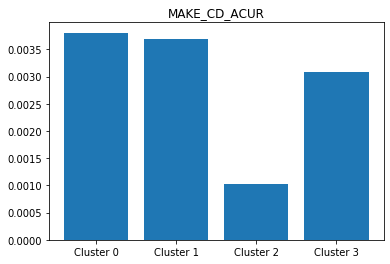

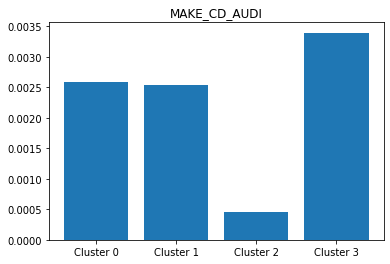

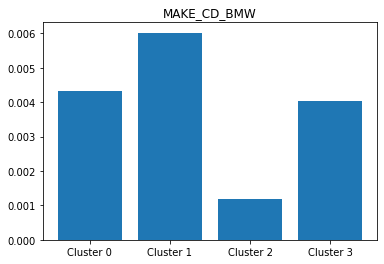

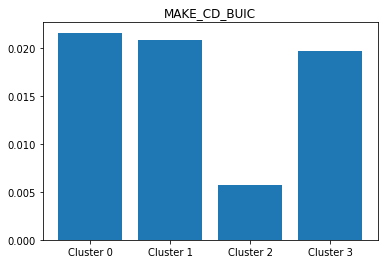

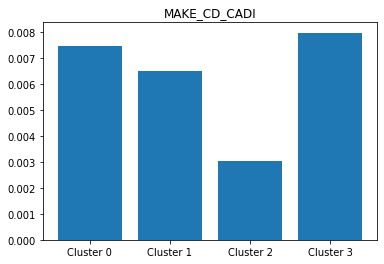

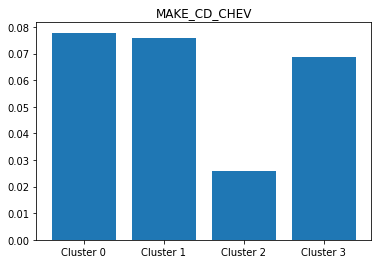

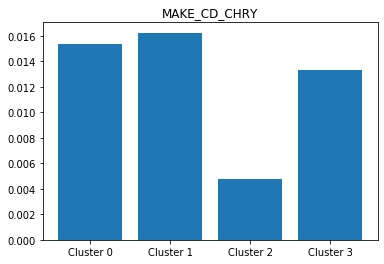

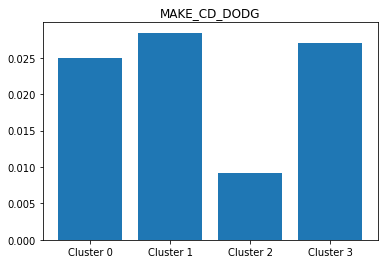

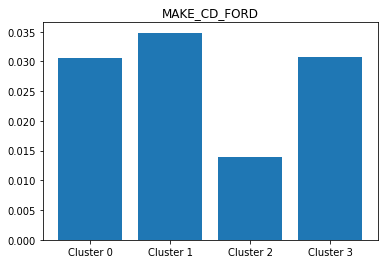

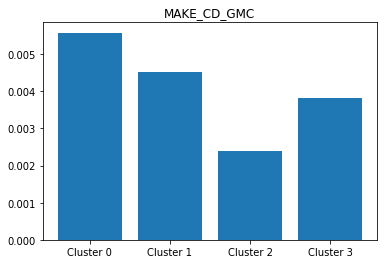

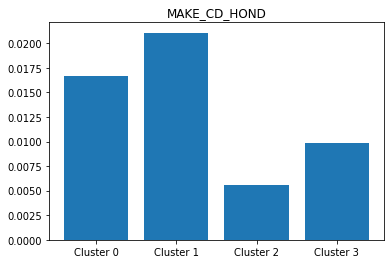

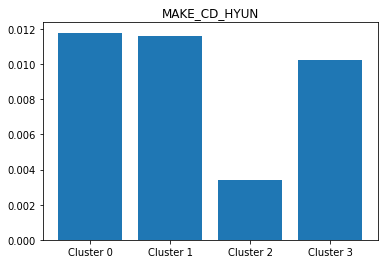

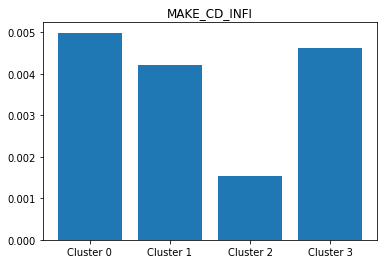

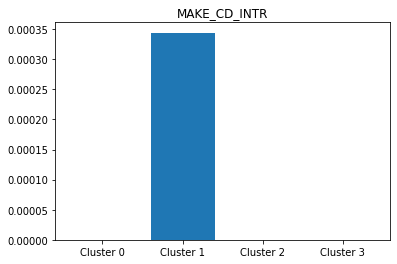

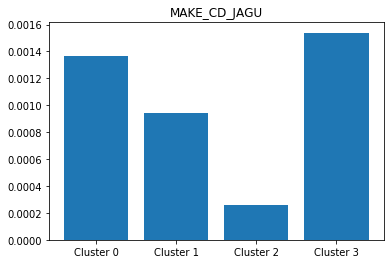

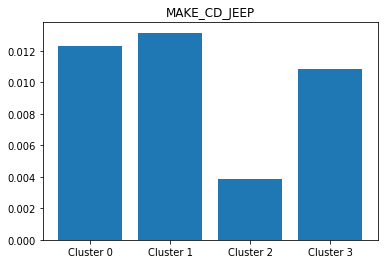

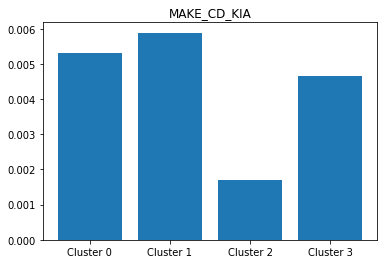

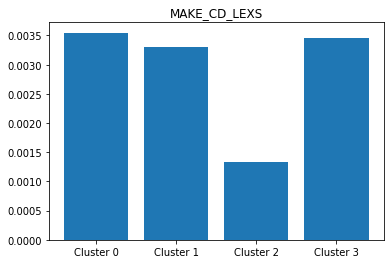

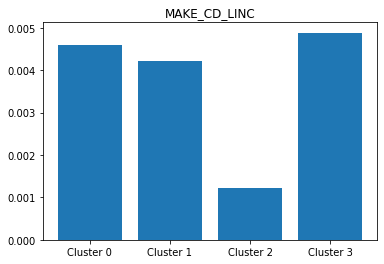

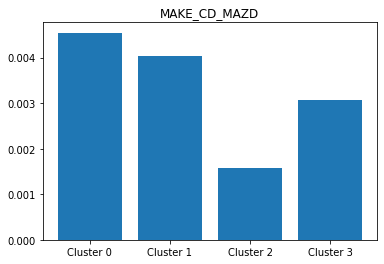

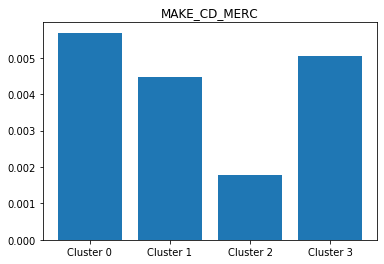

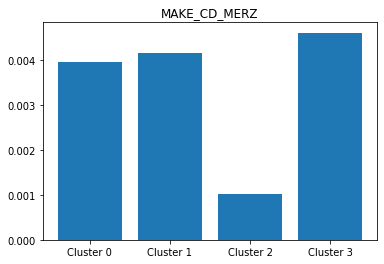

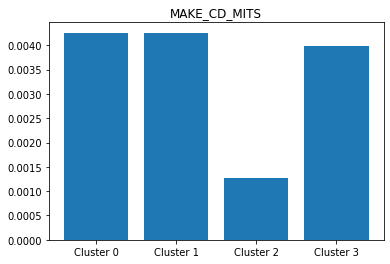

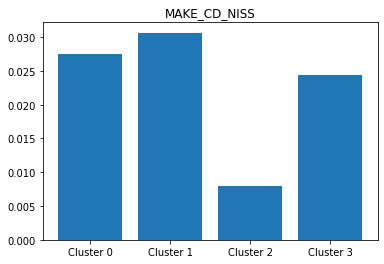

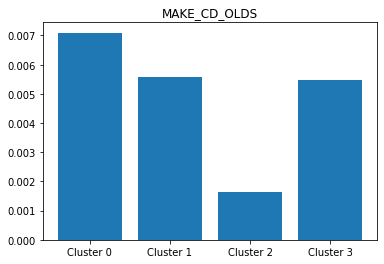

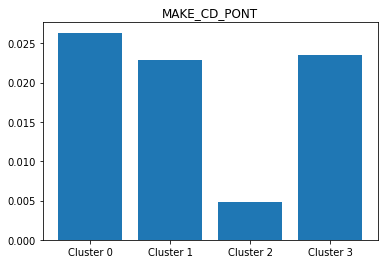

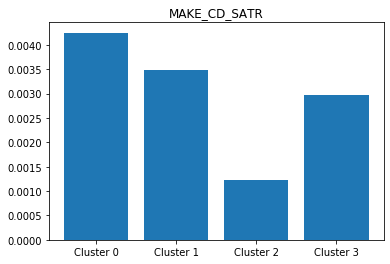

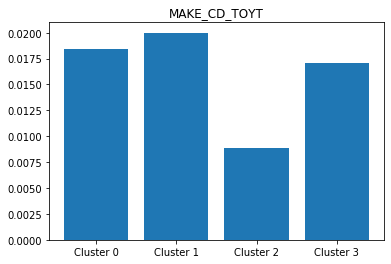

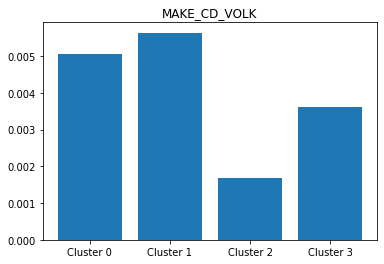

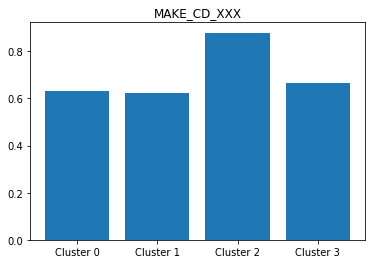

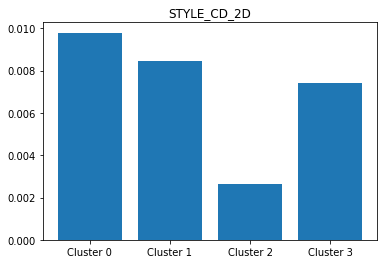

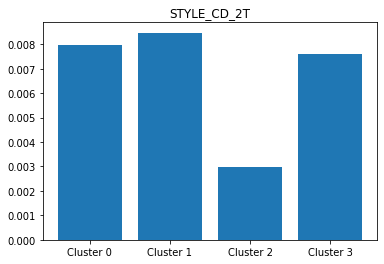

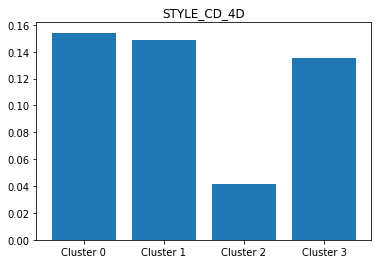

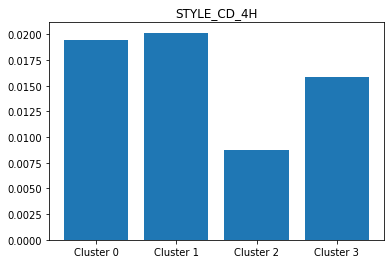

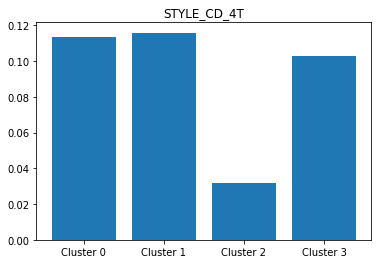

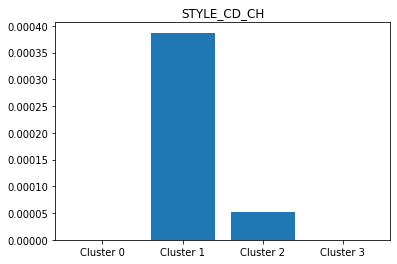

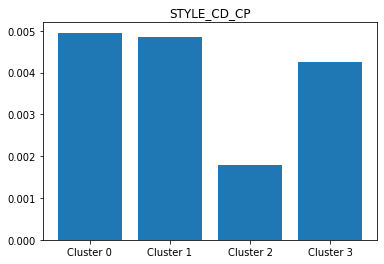

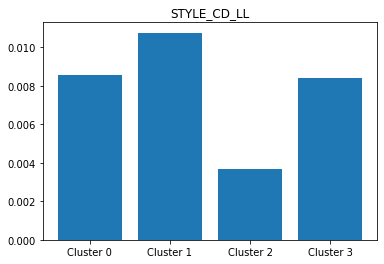

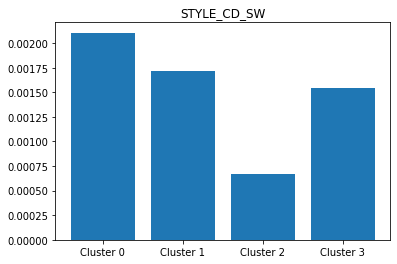

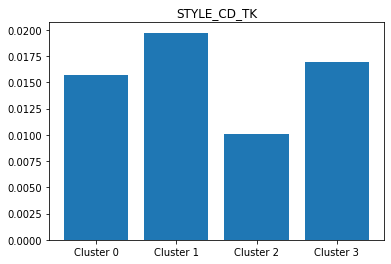

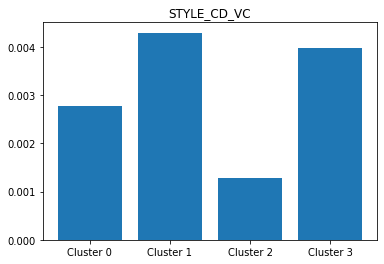

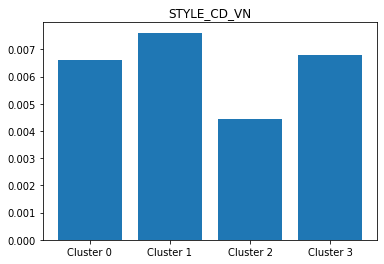

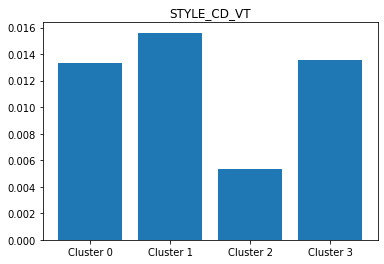

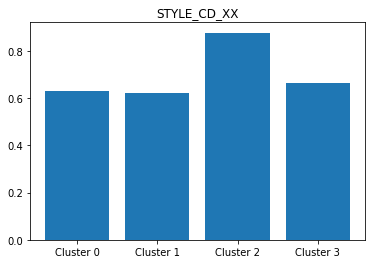

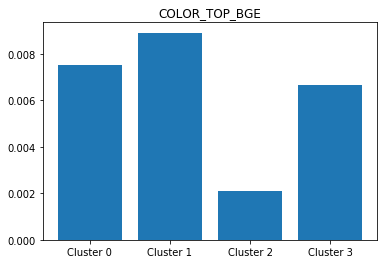

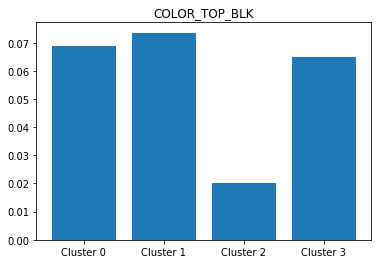

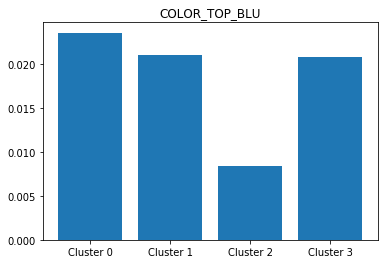

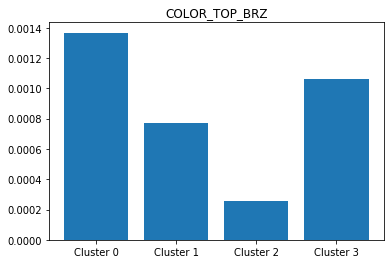

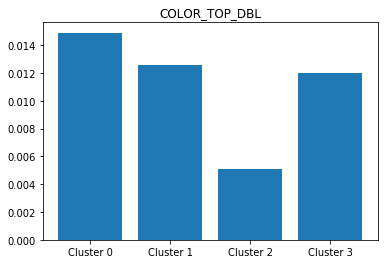

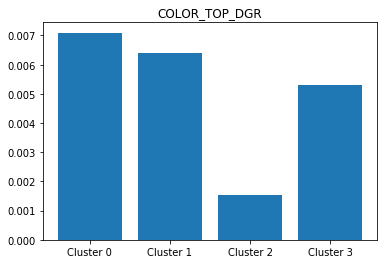

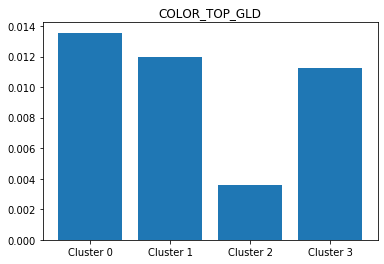

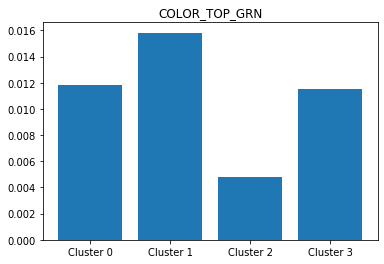

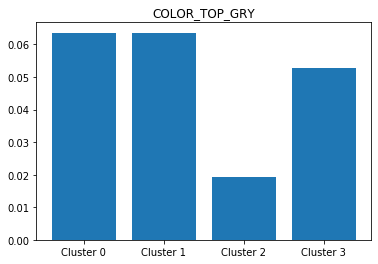

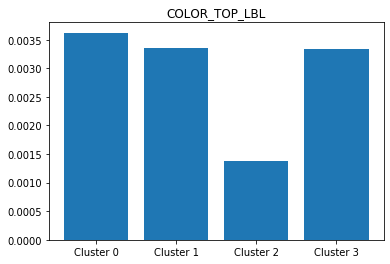

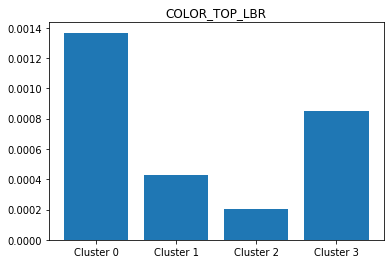

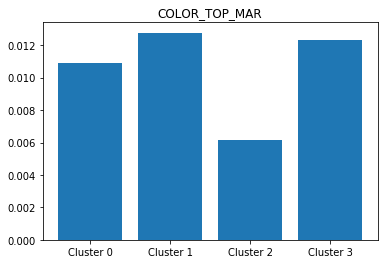

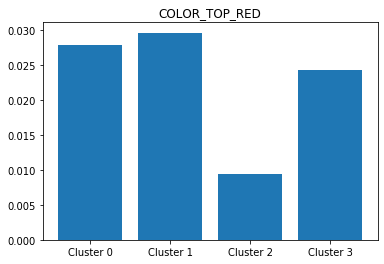

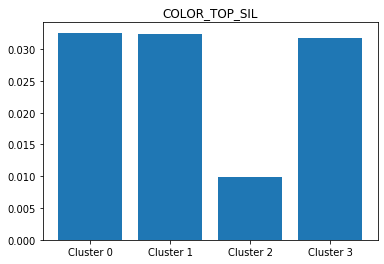

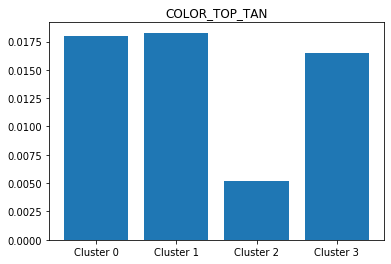

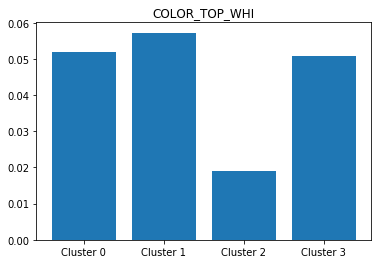

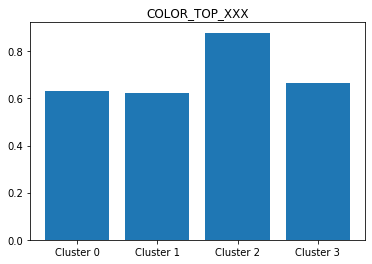

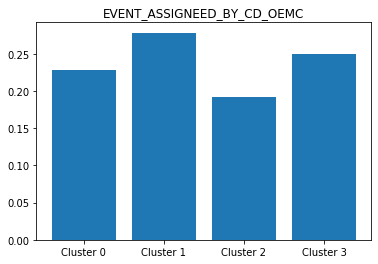

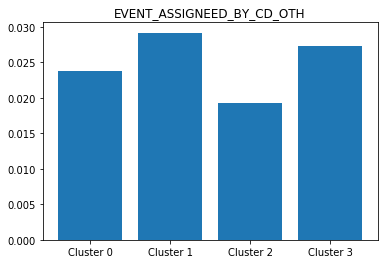

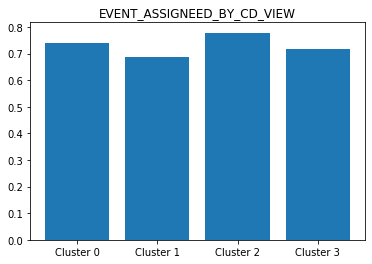

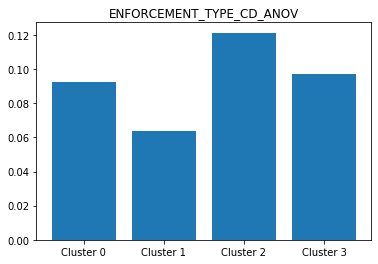

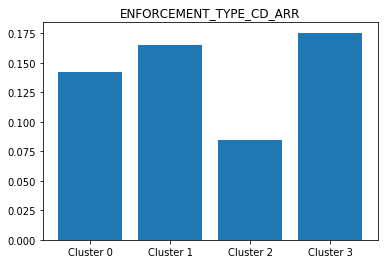

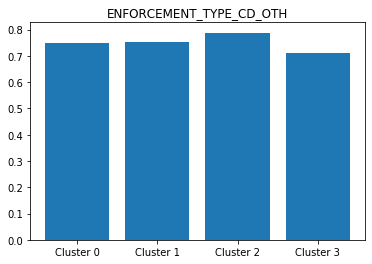

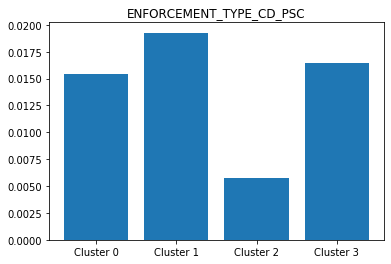

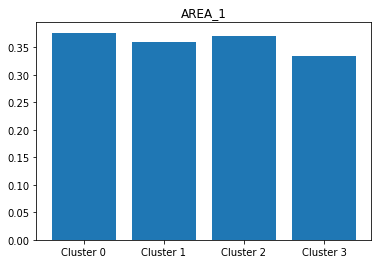

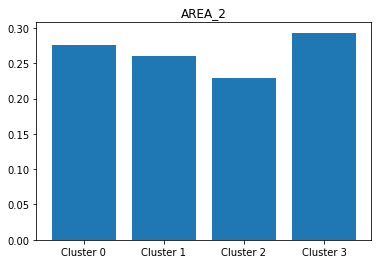

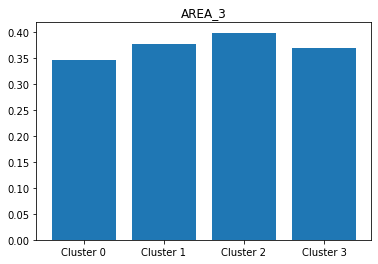

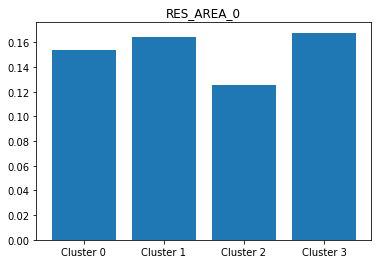

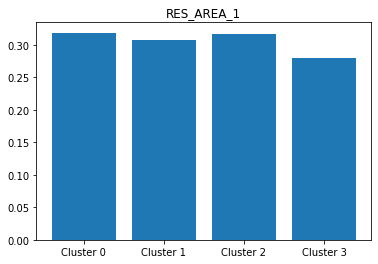

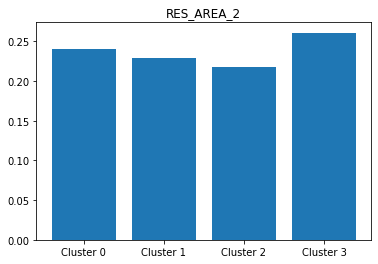

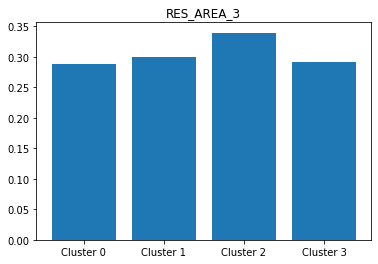

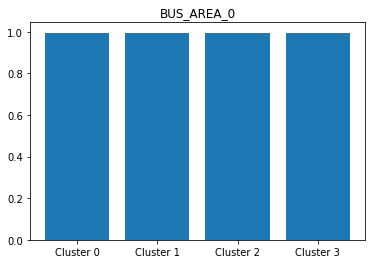

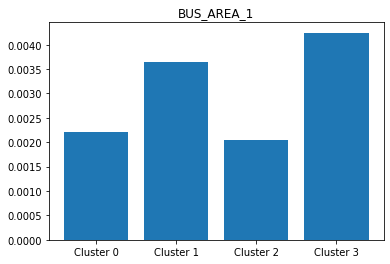

In [74]:
for col in sig_features:

    plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means[col])
    plt.title(col)
    plt.show()

In [75]:
for col in sig_features:
    print(results[col])

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: CONTACT_HOUR, dtype: float64
0    0.0
1    0.0
2    1.0
3    0.0
4    1.0
5    1.0
Name: NAME_VERIFIED_I, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: AGE, dtype: float64
0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: HEIGHT, dtype: float64
0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: WEIGHT, dtype: float64
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
Name: HANDCUFFED_I, dtype: float64
0    0.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
Name: VEHICLE_INVOLVED_I, dtype: float64
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
Name: DISPERSAL_TIME, dtype: float64
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
Name: NUMBER_OF_PERSONS_DISPERSED, dtype: float64
0    0.0
1    1.0
2    0.0
3    1.0
4    0.0
5    1.0
Name: GANG_LOOKOUT_I, dtype: float64
0    0.0
1    1.0
2    0.0
3    1.0
4    1.0
5    1.0
Name: GANG_SECURITY_I, dtype: float64
0    0.0
1 

Cluster 0: SEX_CODE_CD_F, RACE_CODE_CD_WHT

Cluster 1: SEARCH_CANNABIS_I, SEARCH_HEROIN_I, SEARCH_CANNABIS_AMOUNT, SEARCH_HEROIN_AMOUNT

Cluster 2: GANG_NARCOTIC_RELATED_I, AGE, HANDCUFFED_I, NUMBER_OF_PERSONS_DISPERSED, PAT_DOWN_I, SEARCH_I, SEX_CODE_CD_X

Cluster 3: SEX_CODE_CD_F, HEIGHT, WEIGHT, WEAPON_OR_CONTRABAND_FOUND_I, CANNABIS_I, COCAINE_I, RACE_CODE_CD_BLK, RACE_CODE_CD_WHT

## Cluster 0

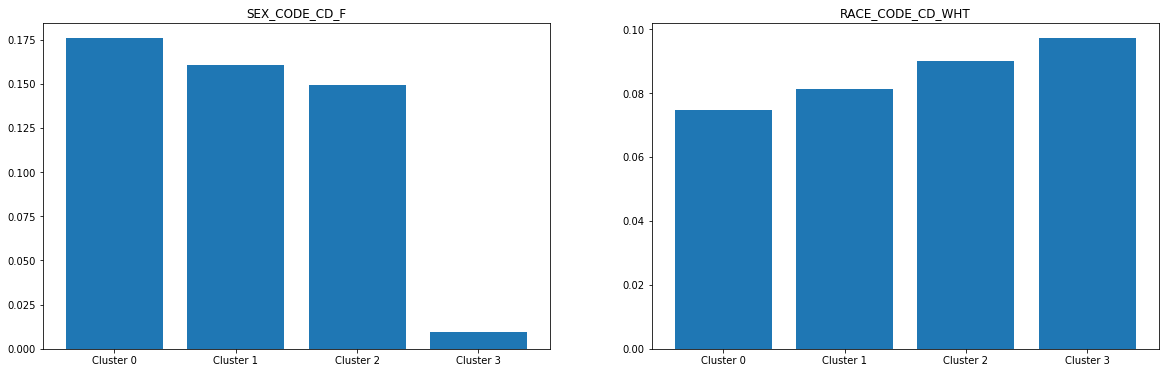

In [76]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEX_CODE_CD_F'])
plt.title('SEX_CODE_CD_F')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['RACE_CODE_CD_WHT'])
plt.title('RACE_CODE_CD_WHT')

plt.show()

## Cluster 1

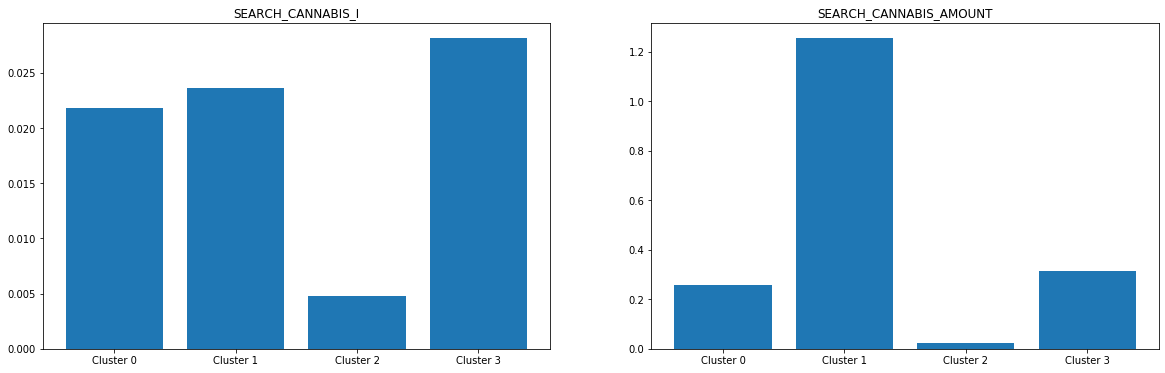

In [77]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_CANNABIS_I'])
plt.title('SEARCH_CANNABIS_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_CANNABIS_AMOUNT'])
plt.title('SEARCH_CANNABIS_AMOUNT')

plt.show()

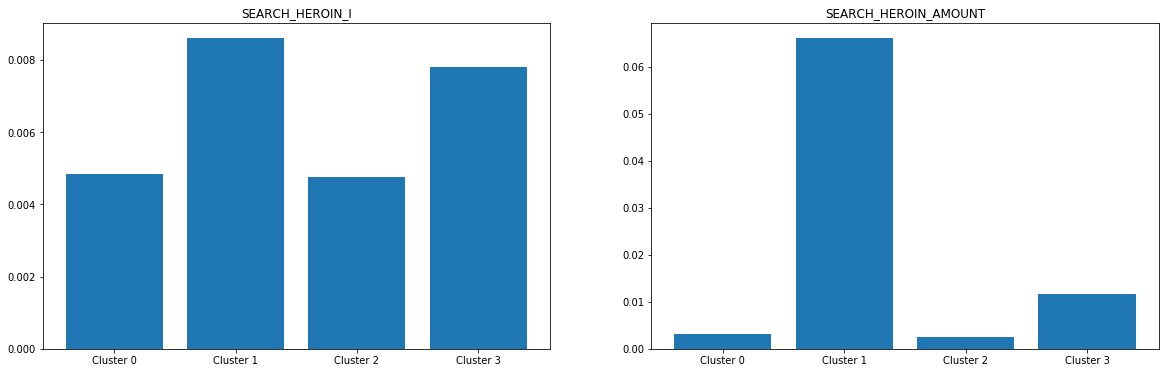

In [78]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_HEROIN_I'])
plt.title('SEARCH_HEROIN_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_HEROIN_AMOUNT'])
plt.title('SEARCH_HEROIN_AMOUNT')

plt.show()

## Cluster 2

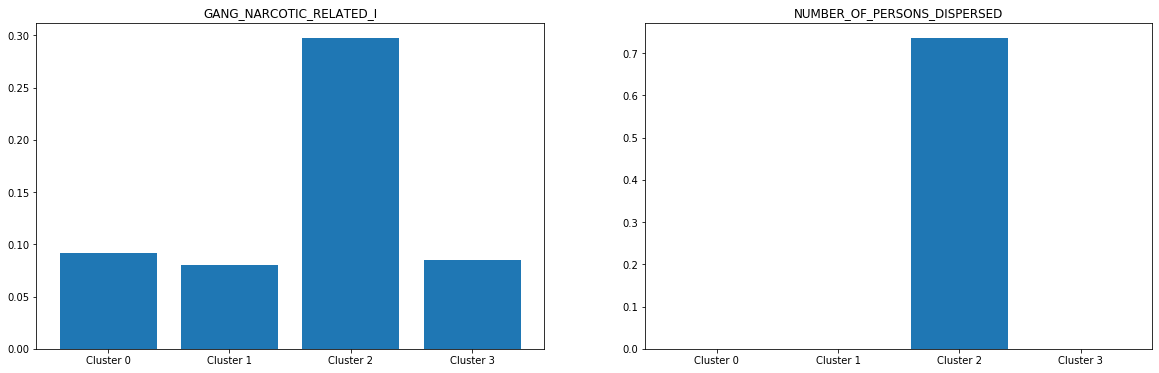

In [79]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['GANG_NARCOTIC_RELATED_I'])
plt.title('GANG_NARCOTIC_RELATED_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['NUMBER_OF_PERSONS_DISPERSED'])
plt.title('NUMBER_OF_PERSONS_DISPERSED')

plt.show()

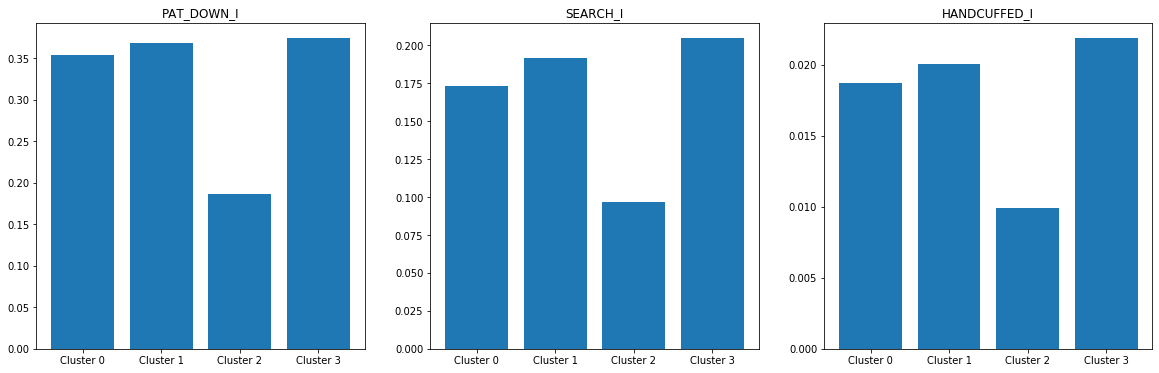

In [80]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['PAT_DOWN_I'])
plt.title('PAT_DOWN_I')

plt.subplot(1, 3, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_I'])
plt.title('SEARCH_I')

plt.subplot(1, 3, 3)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['HANDCUFFED_I'])
plt.title('HANDCUFFED_I')

plt.show()

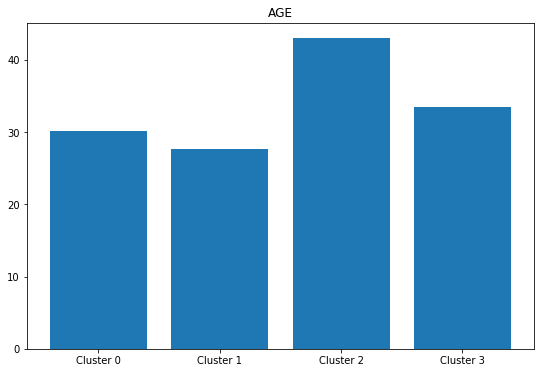

In [81]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['AGE'])
plt.title('AGE')

plt.show()

## Cluster 3

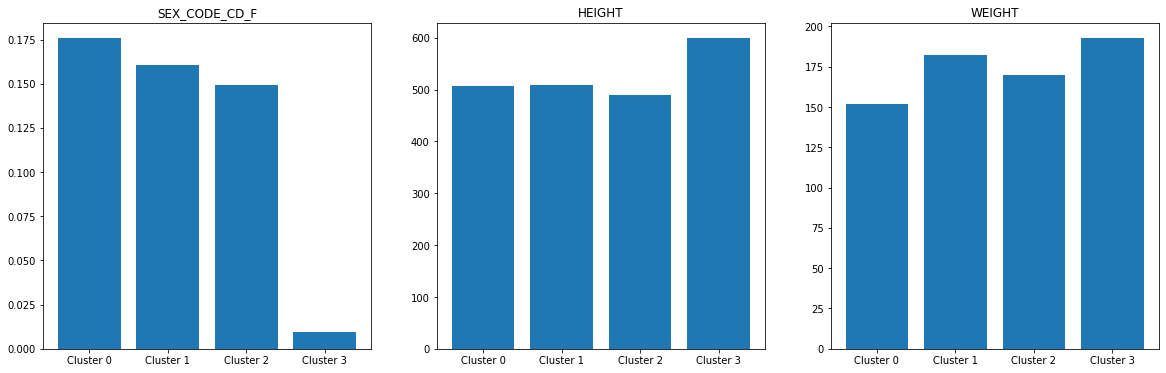

In [82]:
plt.figure(figsize=(20,6))
plt.subplot(1, 3, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEX_CODE_CD_F'])
plt.title('SEX_CODE_CD_F')

plt.subplot(1, 3, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['HEIGHT'])
plt.title('HEIGHT')

plt.subplot(1, 3, 3)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['WEIGHT'])
plt.title('WEIGHT')

plt.show()

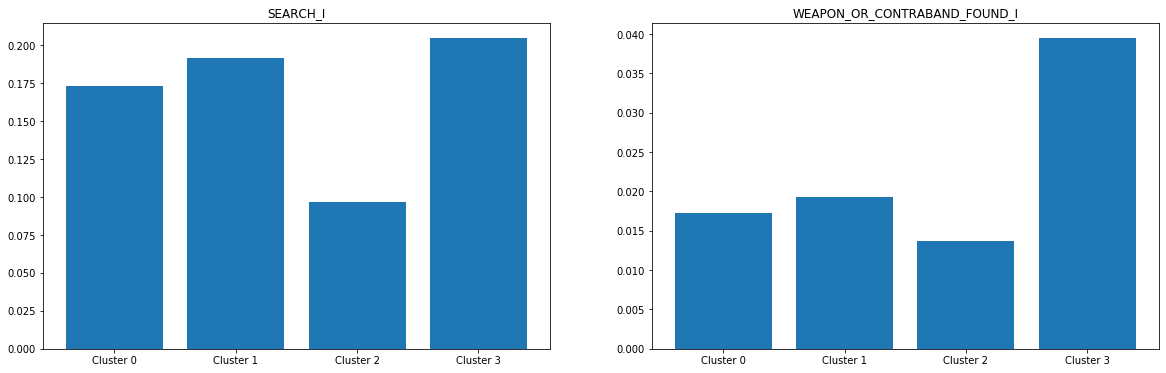

In [83]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['SEARCH_I'])
plt.title('SEARCH_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['WEAPON_OR_CONTRABAND_FOUND_I'])
plt.title('WEAPON_OR_CONTRABAND_FOUND_I')

plt.show()

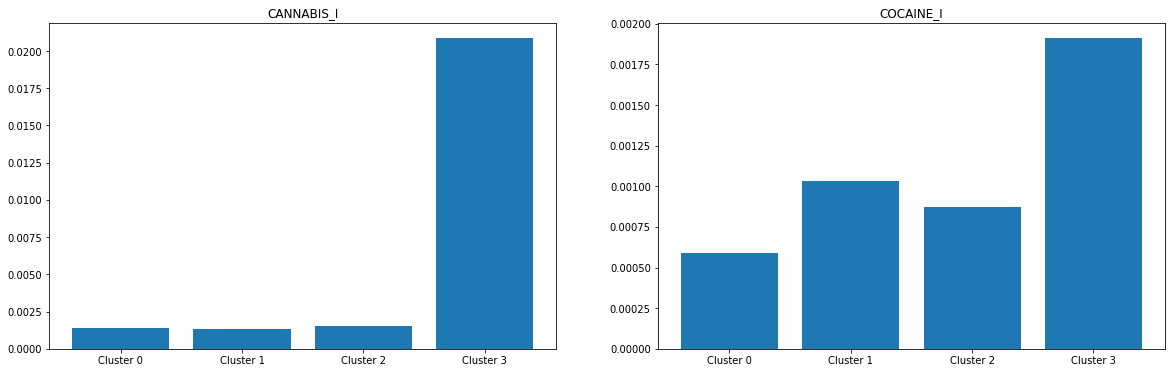

In [84]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['CANNABIS_I'])
plt.title('CANNABIS_I')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['COCAINE_I'])
plt.title('COCAINE_I')

plt.show()

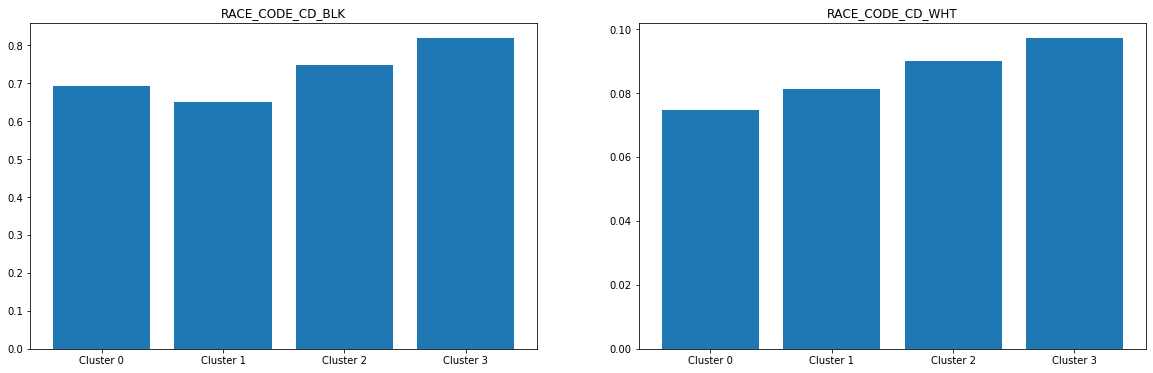

In [85]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['RACE_CODE_CD_BLK'])
plt.title('RACE_CODE_CD_BLK')

plt.subplot(1, 2, 2)
plt.bar(x=['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3'], height=cluster_means['RACE_CODE_CD_WHT'])
plt.title('RACE_CODE_CD_WHT')

plt.show()